In [13]:
REPO = '../'
RESULT_TABLE = f'{REPO}/data/table'
RESULT_OBJ = f'{REPO}/data/object'
FIGURE_FOLDER= f'{REPO}/data/figure'
SETTING_FOLDER = f'{REPO}/data/setting'
EXTERNAL_DATA=f'{REPO}/data/external'

import sys
sys.path.append(REPO)
from settings import COLOR_PAlETTE
from utils.visual import *
from utils.statsTest import lmTest

import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scPipe as sp
import scanpy as sc
import seaborn as sns
import warnings
import commentjson

### Additional Colormap
with open(f'{SETTING_FOLDER}/ColorMap.json','r') as f:
    colormap = commentjson.load(f)
COLOR_PAlETTE.update(colormap)
plt.style.use(f'{REPO}/paper.mplstyle')
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
obs_path = f'{RESULT_TABLE}/GEX_OBS_Lineage.csv'
## Load data
adata = sc.read(f'{RESULT_OBJ}/gex_all.h5ad')
obs = pd.read_csv(obs_path,index_col=0)
adata = adata[adata.obs.index.isin(obs.index[obs.Lineage=='Myeloid']),:].copy()
adata.obs['scSHC' ]=pd.read_csv(f"{RESULT_TABLE}/scSHC/Myeloid_clusters.csv",index_col=0)['x'].astype(str)
print(f'{adata.obs.shape[0]:,} Myeloid cells')

15,953 Myeloid cells


# GEX log1p Normalization

In [15]:
sp.utils.log1pNorm(adata)

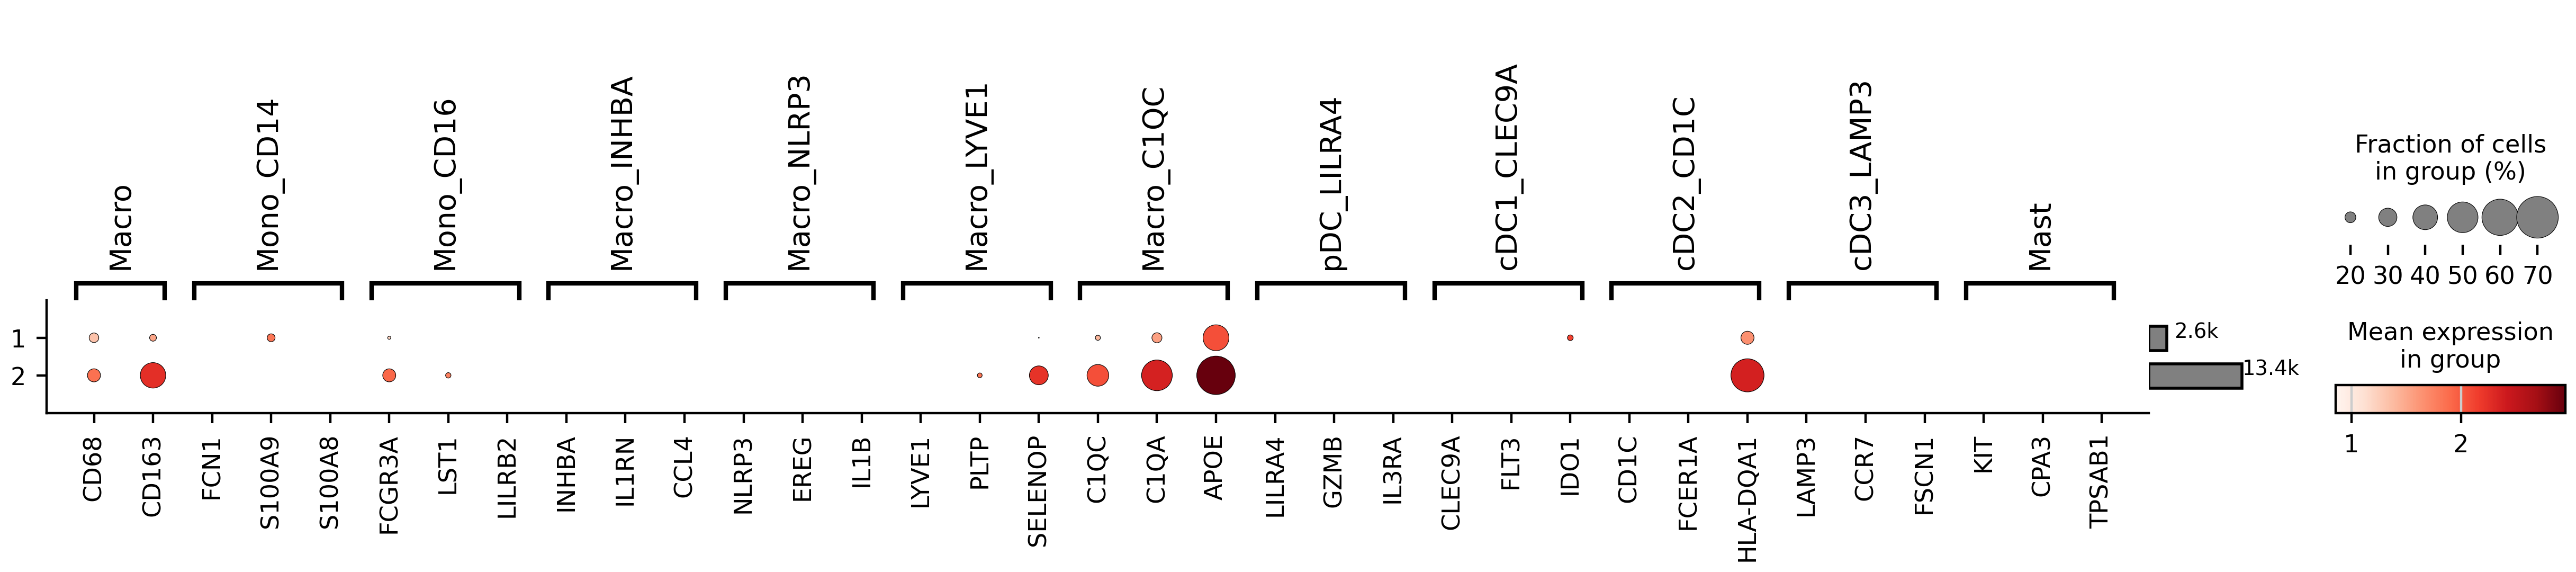

In [16]:
markers = {
    "Macro":['CD68','CD163'],
    "Mono_CD14":['FCN1','S100A9','S100A8'],
    "Mono_CD16":['FCGR3A','LST1','LILRB2'],
    "Macro_INHBA":['INHBA','IL1RN','CCL4'],
    "Macro_NLRP3":['NLRP3','EREG','IL1B'],
    "Macro_LYVE1":['LYVE1','PLTP','SELENOP'],
    "Macro_C1QC":['C1QC','C1QA','APOE'],
    "pDC_LILRA4":['LILRA4','GZMB','IL3RA'],
    "cDC1_CLEC9A":['CLEC9A','FLT3','IDO1'],
    "cDC2_CD1C":['CD1C','FCER1A','HLA-DQA1'],
    "cDC3_LAMP3":['LAMP3','CCR7','FSCN1'],
    "Mast":['KIT','CPA3','TPSAB1']
}
sc.settings.set_figure_params(dpi=200,fontsize=10)
dp=sc.pl.dotplot(
    adata,
    var_names=markers,
    groupby='scSHC',
    mean_only_expressed=True,
    return_fig=True,
)
dp.add_totals(color='gray').style(dot_edge_color='black',cmap='Reds',dot_min=.1)
dp.show()

In [17]:
adata.obs['Celltype'] = adata.obs['scSHC'].map({
    '1':'Myeloid',
    '2':'Macs'
})
adata.obs[['Celltype']].to_csv(f"{RESULT_TABLE}/annotation/Myeloid.csv")
adata.obs['Celltype'].value_counts()

Macs       13375
Myeloid     2578
Name: Celltype, dtype: int64

# Macrophage

In [18]:
adata = adata[adata.obs['Celltype']=='Macs',:]

In [18]:
adata.obs.Cellstate = pd.Categorical(adata.obs.Cellstate,
                                    ['Macs.Endocytosis','Macs.Lipid','Macs.Secretion','Macs.Adhesion','Macs.Presentation','Macs.Interferon'],
                                    ordered=True)

# NRP1 expression

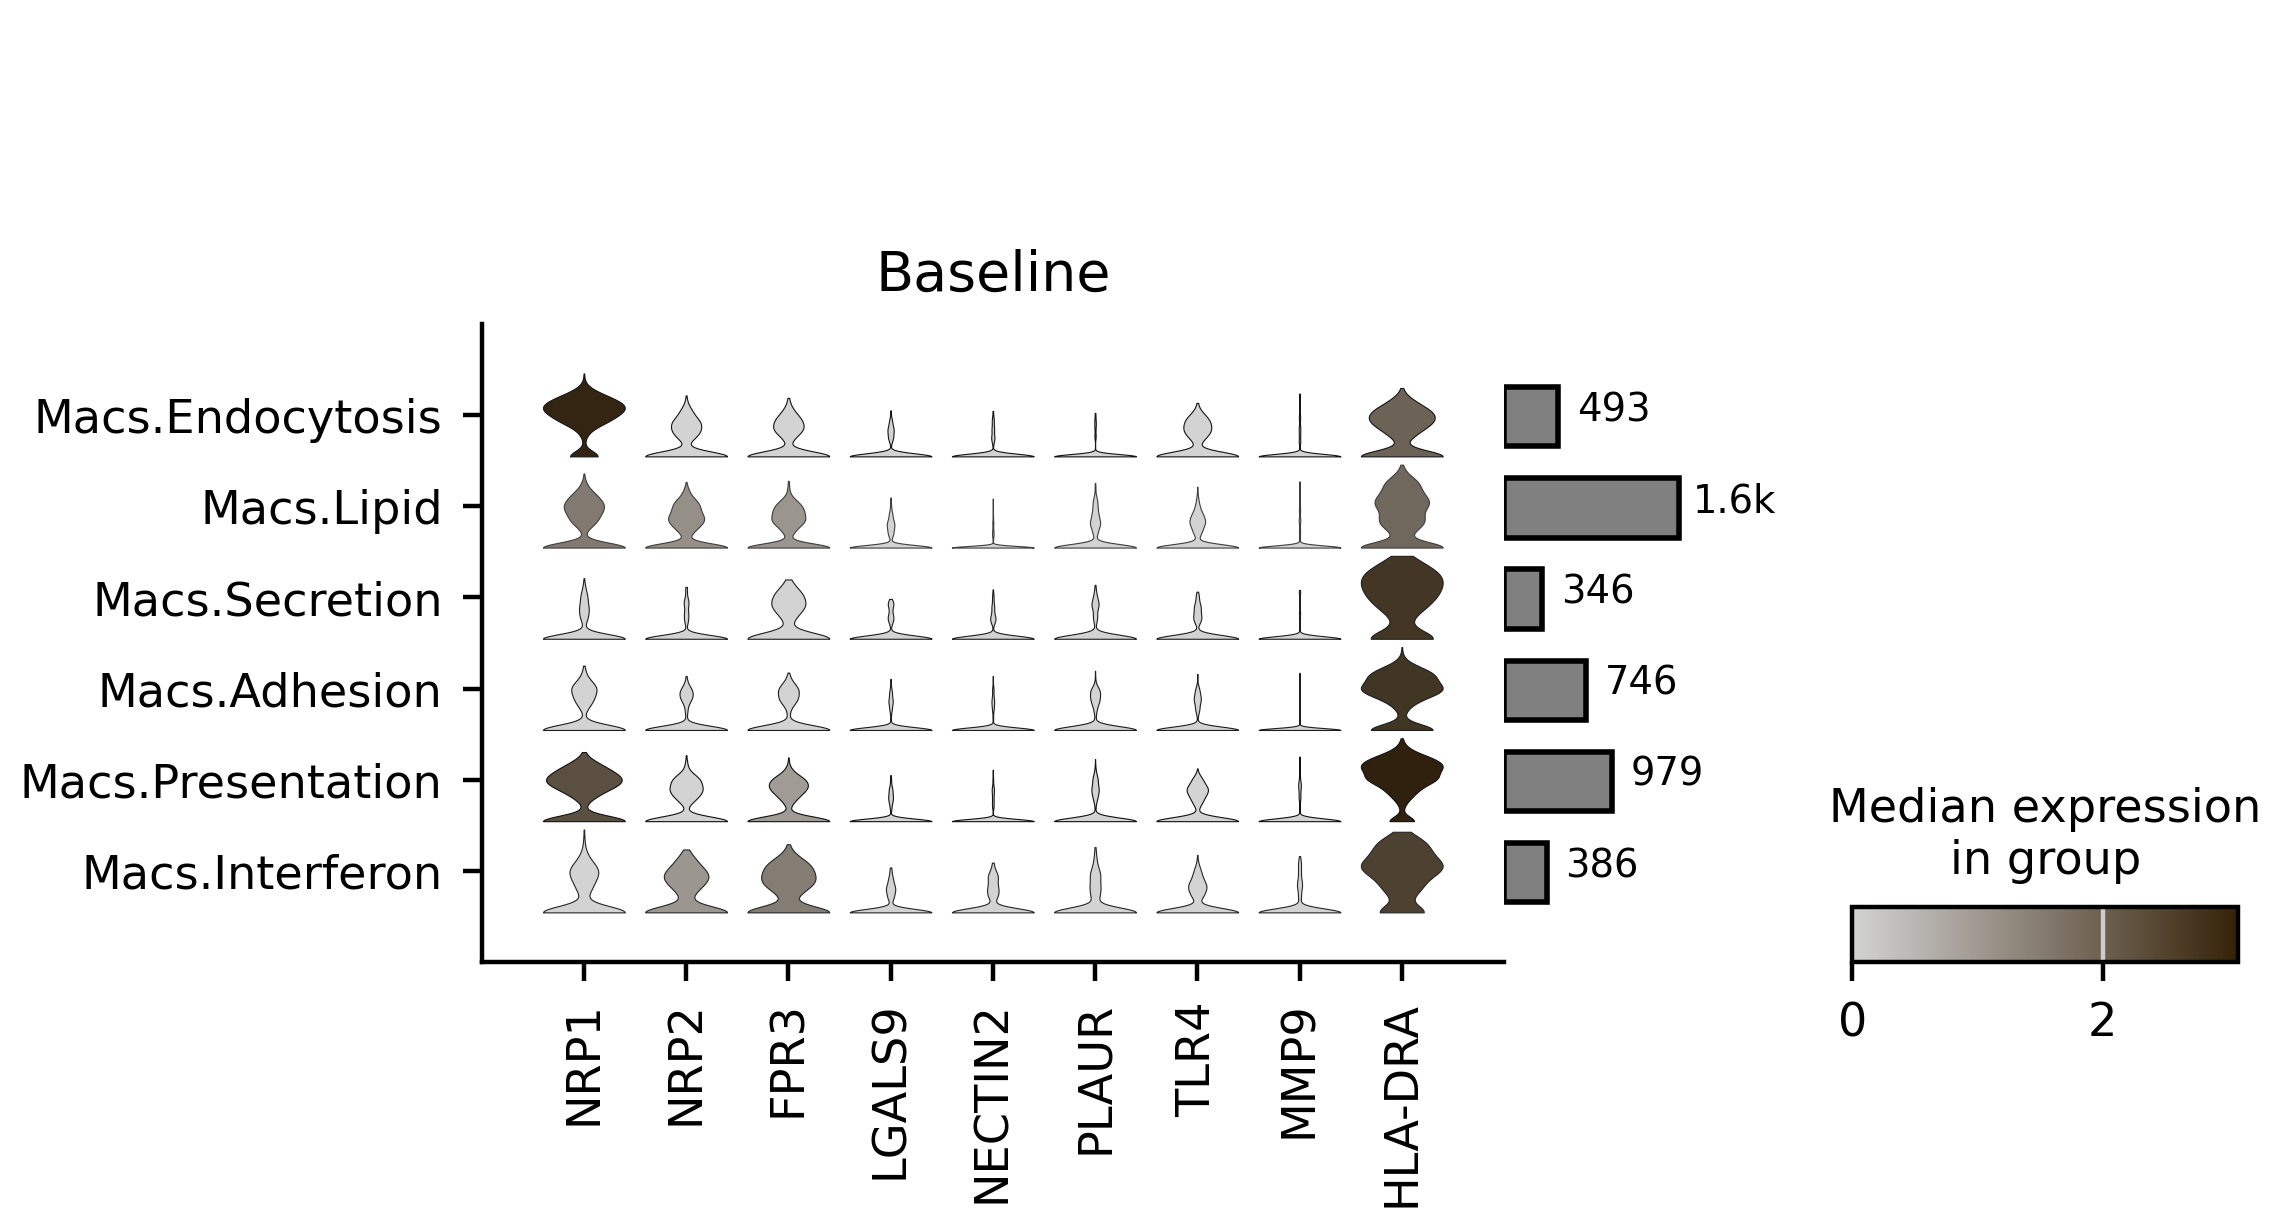

In [19]:
timepoint = 'Baseline'
show_genes = ['NRP1','NRP2','FPR3','LGALS9','NECTIN2','PLAUR','TLR4','MMP9','HLA-DRA']
dp = sc.pl.stacked_violin(adata[adata.obs.Timepoint.isin([timepoint]),:],show_genes,groupby=['Cellstate'],
                    cmap=sns.blend_palette(["lightgray", COLOR_PAlETTE['Timepoint'][timepoint]], as_cmap=True),
                         return_fig=True)
dp.add_totals(color='gray')
dp.get_axes()['mainplot_ax'].set_title(timepoint);

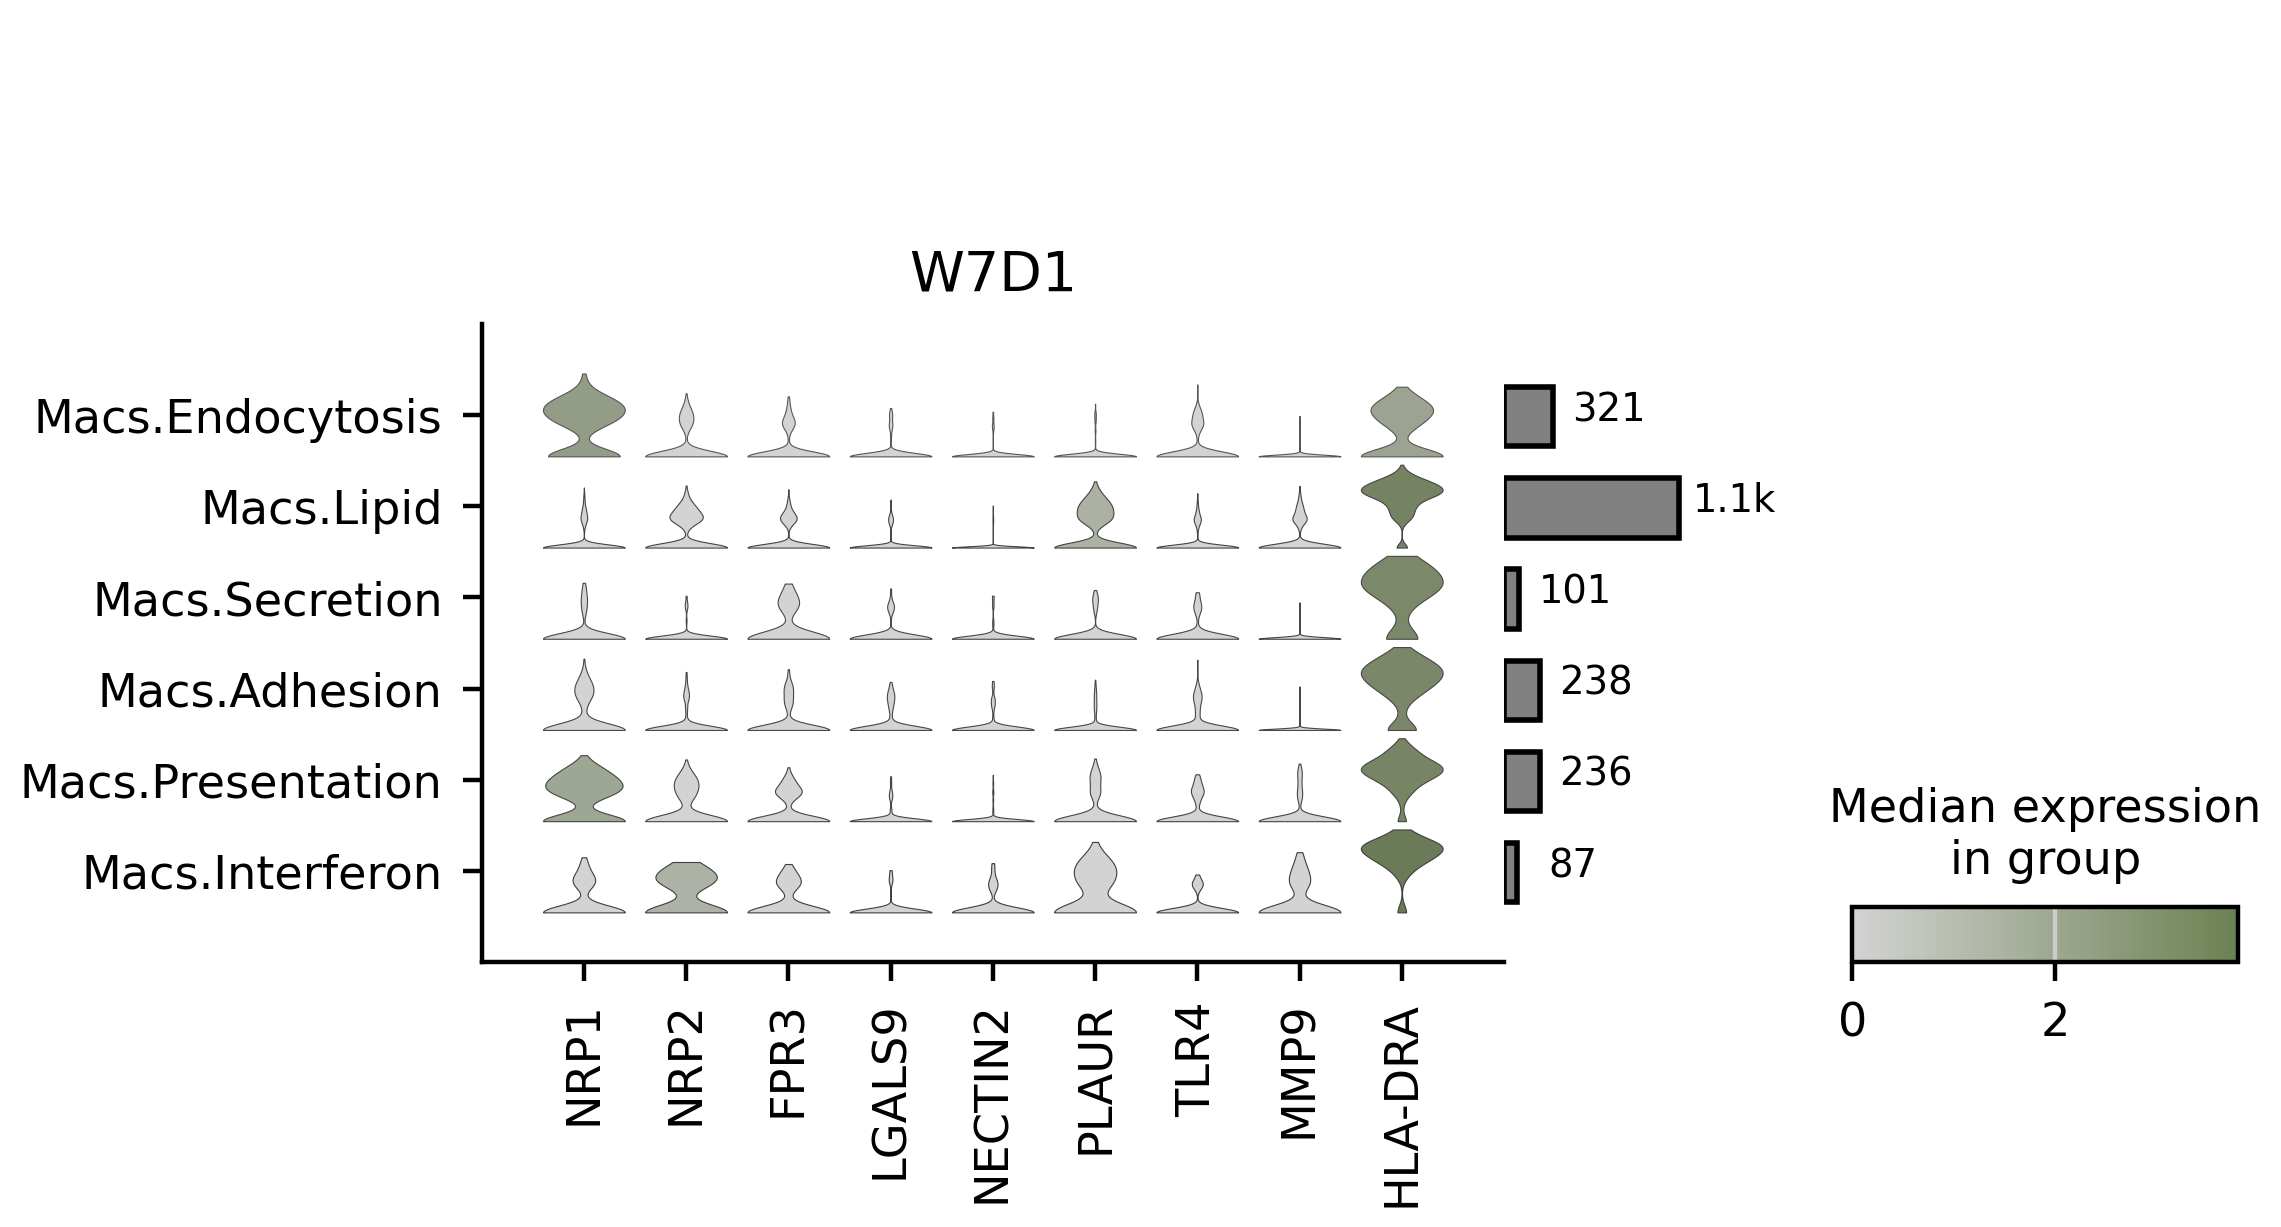

In [20]:
timepoint = 'W7D1'
dp = sc.pl.stacked_violin(adata[adata.obs.Timepoint.isin([timepoint]),:],show_genes,groupby=['Cellstate'],
                    cmap=sns.blend_palette(["lightgray", COLOR_PAlETTE['Timepoint'][timepoint]], as_cmap=True),
                         return_fig=True)
dp.add_totals(color='gray')
dp.get_axes()['mainplot_ax'].set_title(timepoint);

## Baseline L-R expression

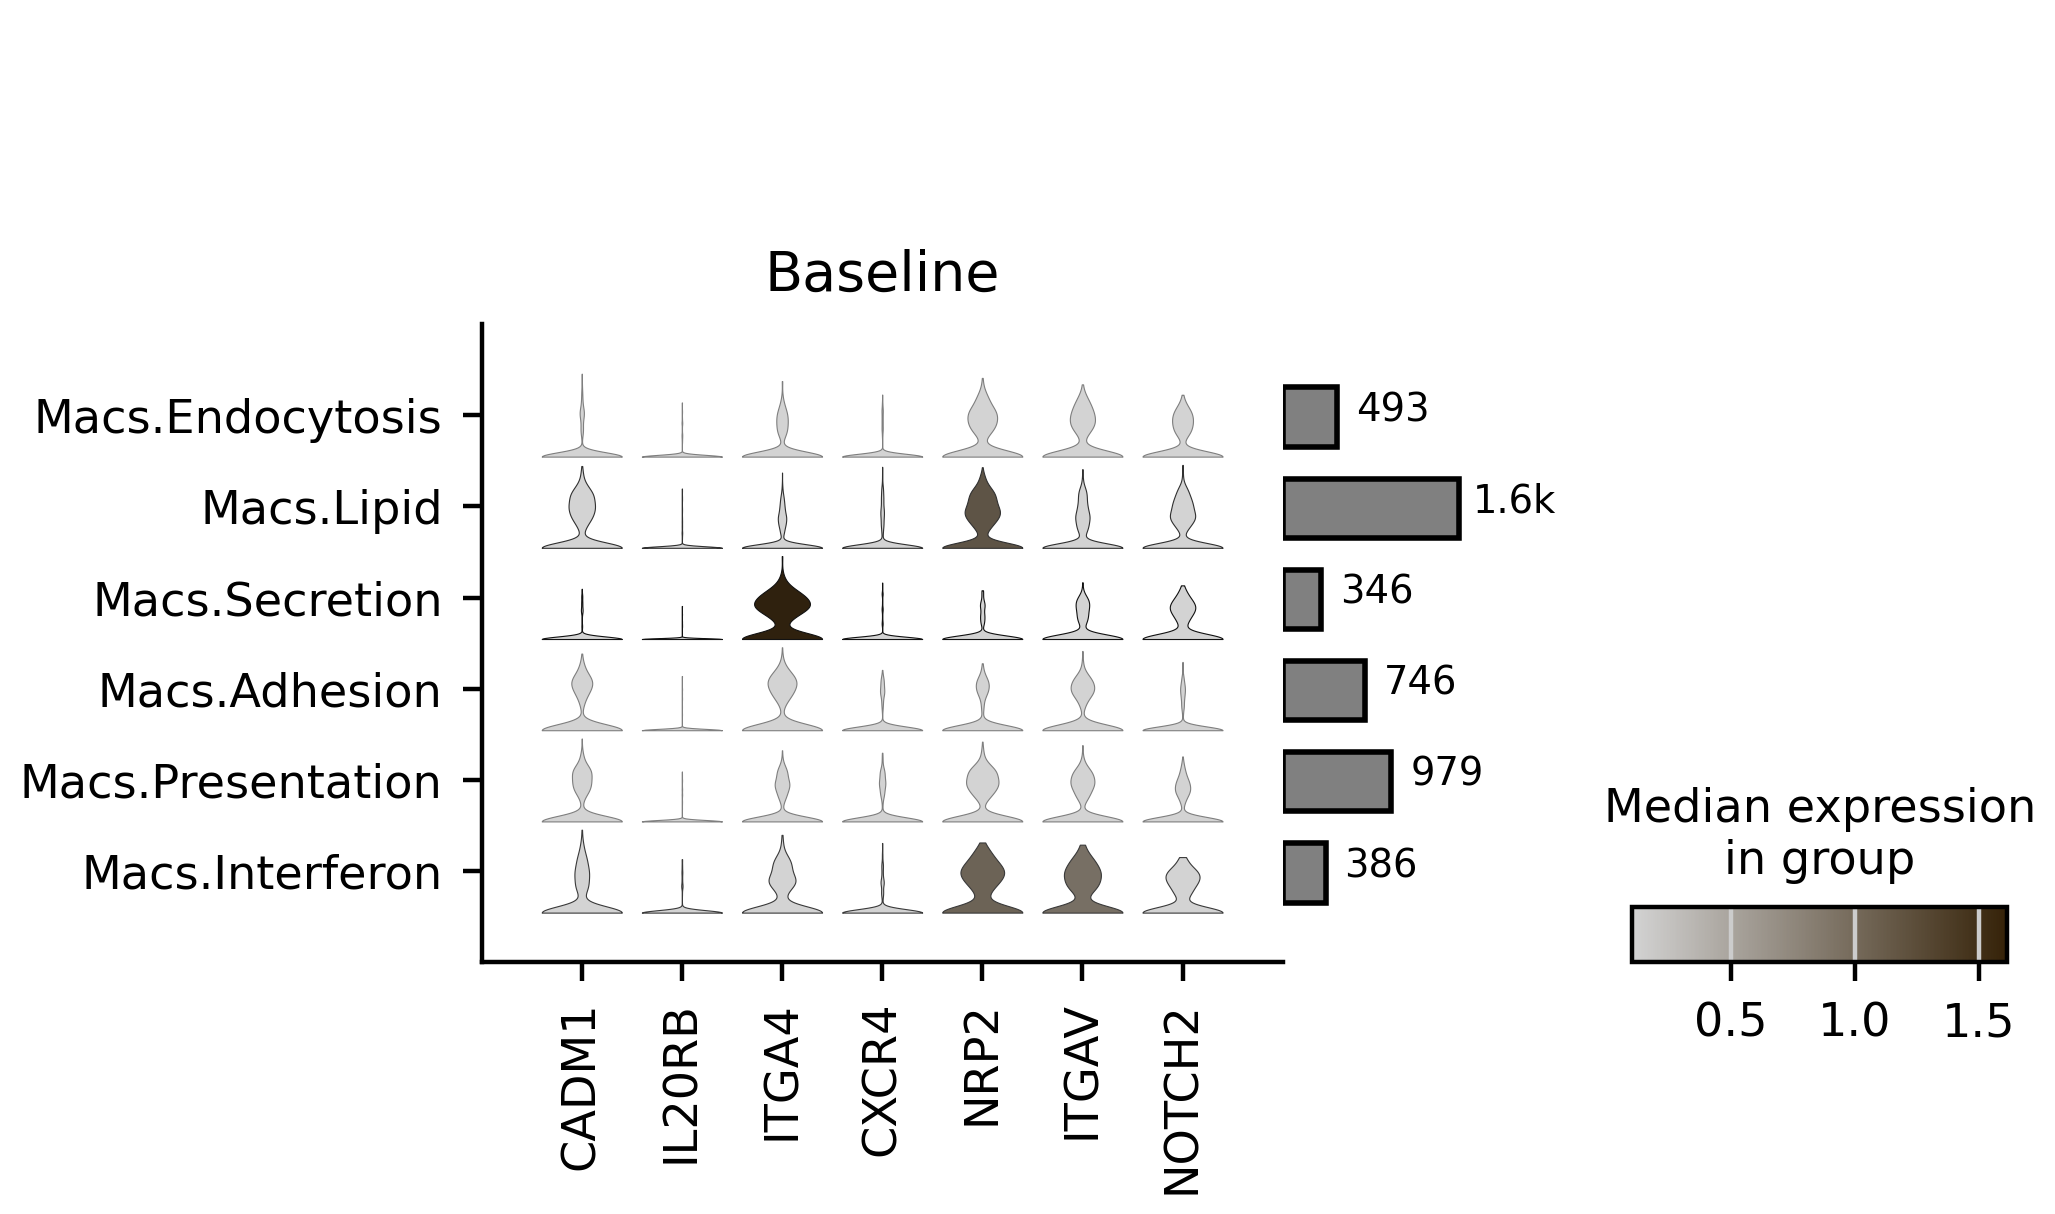

In [21]:
timepoint = 'Baseline'

dp = sc.pl.stacked_violin(adata[adata.obs.Timepoint.isin([timepoint]),:],['CADM1','IL20RB','ITGA4','CXCR4','NRP2','ITGAV','NOTCH2'],groupby=['Cellstate'],
                    cmap=sns.blend_palette(["lightgray", COLOR_PAlETTE['Timepoint'][timepoint]], as_cmap=True),
                          vmin=.1,
                         return_fig=True)
dp.add_totals(color='gray')
dp.get_axes()['mainplot_ax'].set_title(timepoint);

# Heatmap visualization on genes in each MPs

## Load MPs geneset

In [22]:
ref_ITH=pd.read_table(mp_gmt_path,header=None,index_col=0).drop([1],axis=1).T
anno = pd.read_csv(mp_anno_path,index_col=0)
MP_anno_map = anno[['MetaProgram','MPs']].drop_duplicates().set_index('MetaProgram')['MPs'].to_dict()
ref_ITH.columns = ref_ITH.columns.map(MP_anno_map)
ref_ITH=ref_ITH.melt()
ref_ITH.columns = ['Program','gene']
ref_ITH = ref_ITH.drop_duplicates(subset=['gene'],keep=False).set_index('gene')

# Score association

In [23]:
# get MP sores on all cells 
scores = pd.read_csv(score_path,index_col=0)
# select the signature scoring method
signature_method ='VISION'
scores = scores[scores.columns[scores.columns.str.endswith(signature_method)]]
scores.columns = scores.columns.map(lambda x:x.split('_')[0])#.map(MP_anno_map)

obs = adata.obs.loc[scores.index,:]
# attach clinical information
scores = scores.merge(obs,left_index=True,right_index=True)

## Score correlation

In [24]:
for x in scores.columns[scores.columns.str.startswith('MP')]:
    adata.obs[MP_anno_map[x]]= scores[x]

In [25]:
order = ['Endocytosis','Lipid','Secretion','Adhesion','Presentation','Interferon']
dt =  adata.obs[order]
pvalues = []
for c in dt:
    p = dt.apply(lambda a: scipy.stats.pearsonr(a.values,dt[c].values)[1])
    p.name= c
    pvalues.append(p)
pvalues = pd.concat(pvalues,axis=1)
corr =  dt.corr()

In [26]:
data = corr.unstack().rename('Correlation').to_frame()
data['pvalue'] = pvalues.unstack()
data['Significance'] = 'N.S'
data.loc[data['pvalue']<0.01,'Significance'] = 'p<0.01'

data = data.reset_index().drop_duplicates(['pvalue','Correlation'])
data = data.loc[data.level_0!=data.level_1,:]

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 28.315333333333335 mm


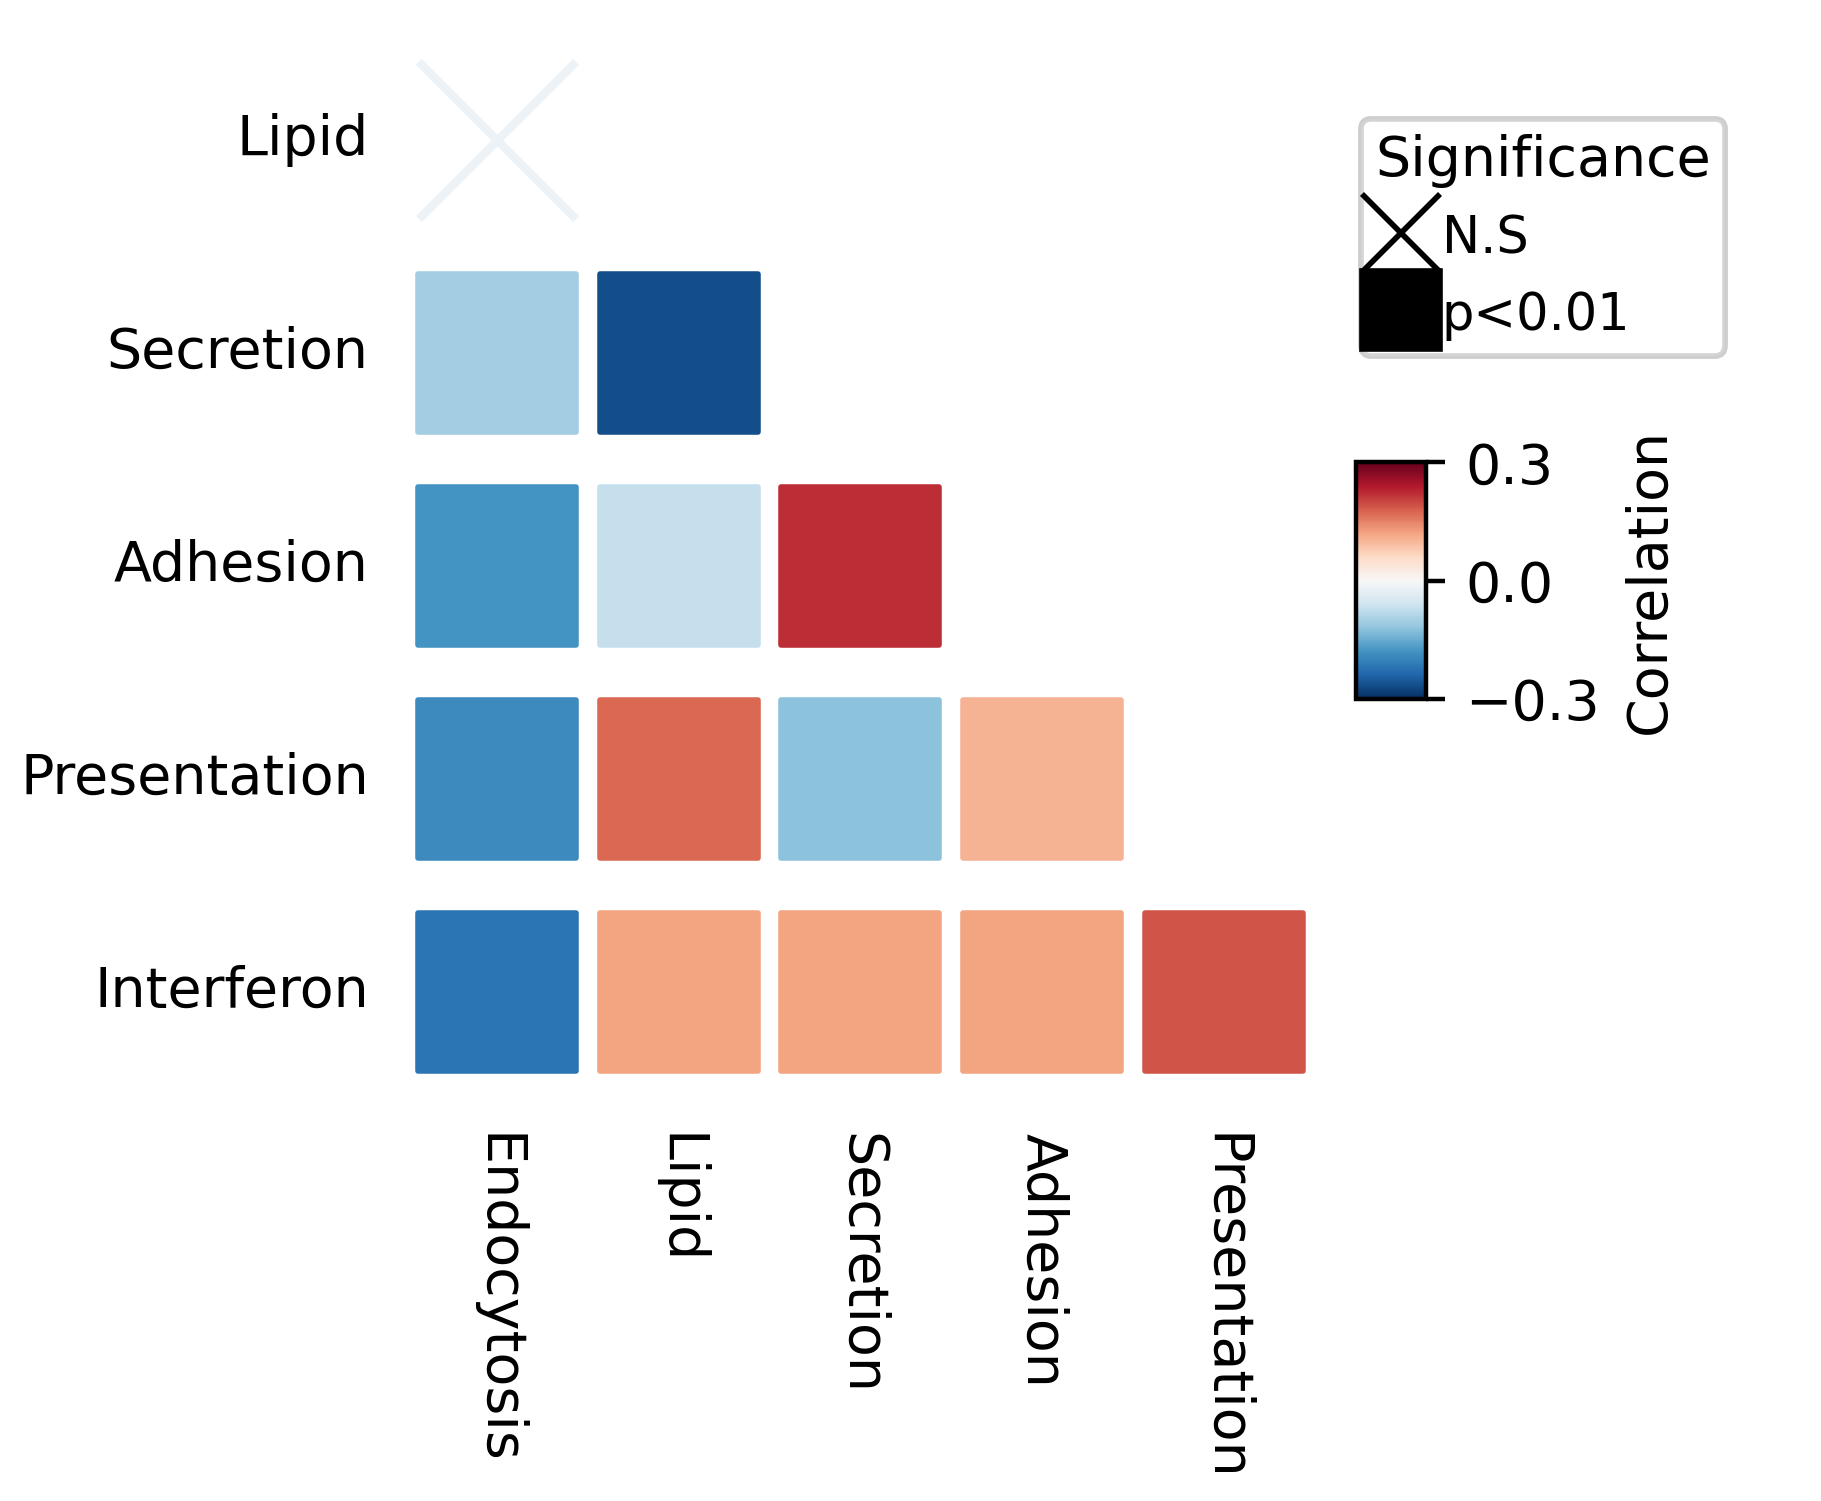

In [28]:
plt.figure(figsize=(3, 3))
plt.rcParams['axes.grid'] = False 
row_ha = HeatmapAnnotation(label=anno_label(pd.Series(order,index=order),colors='k'),axis=0)
col_ha = HeatmapAnnotation(label=anno_label(pd.Series(order,index=order),colors='k'),axis=1)
# col_ha = HeatmapAnnotation(label=anno_label(pd.Series(['Endocytosis','Lipid','Presentation','Interferon','Adhesion','Secretion'])))
cm = DotClustermapPlotter(data=data, x='level_0',y='level_1',value='Correlation',c='Correlation',hue='Significance',
                          s=4,
                          # top_annotation=col_ha,
                          # left_annotation=row_ha,
                          col_split=pd.Series(order[:-1],index=order[:-1]),
                          col_split_order = order[:-1],
                          row_split=pd.Series(order[1:],index=order[1:]),
                          row_split_order = order[1:],
                          marker={'N.S':'x','p<0.01':'s'},
                          vmax=.3,vmin=-.3,cmap='RdBu_r',
                          ratio=200,
                          row_cluster=False,col_cluster=False,
                          show_rownames=True,show_colnames=True,row_names_side='left')
plt.show()

<Axes: >

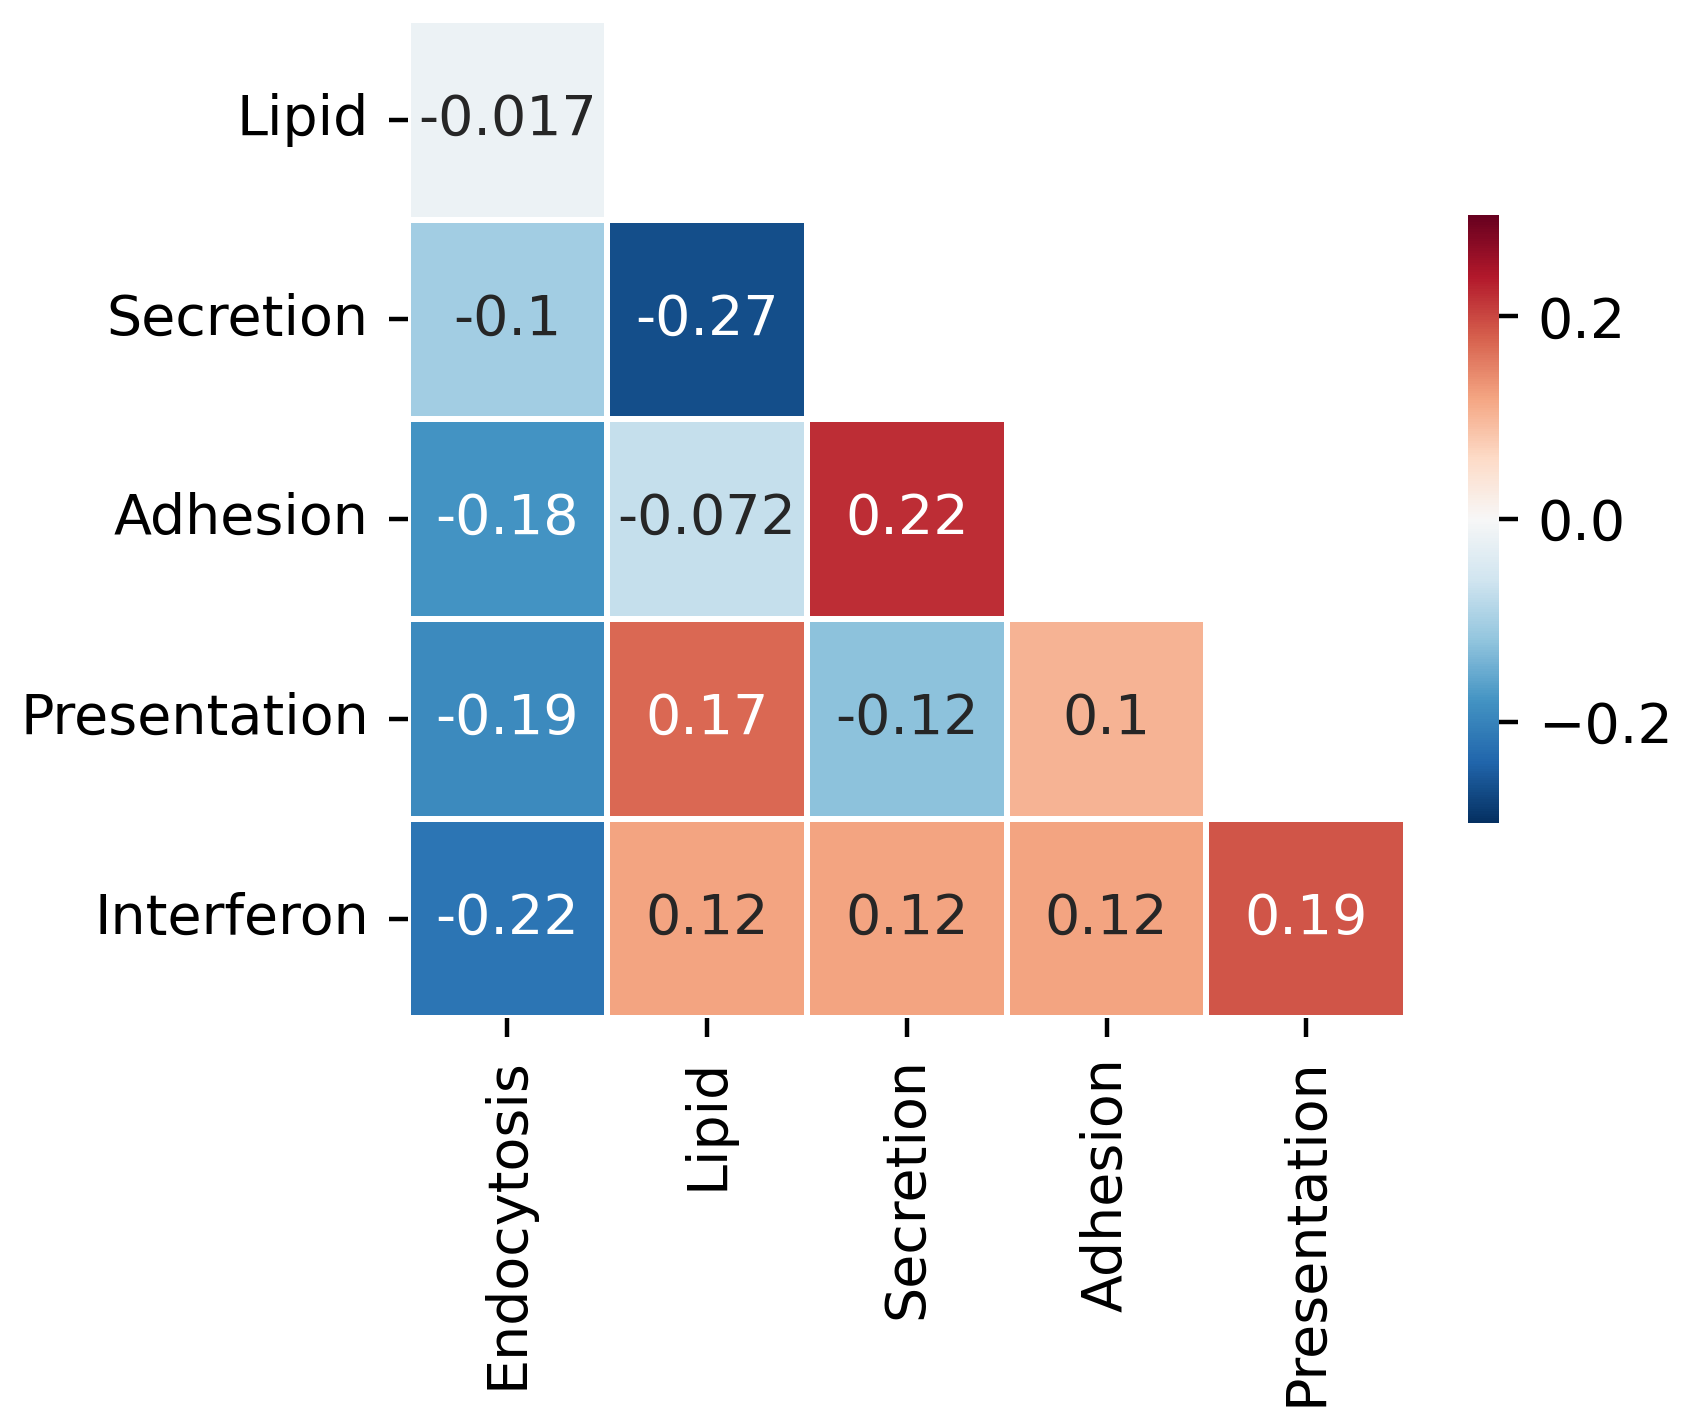

In [29]:
mask = np.triu(corr.iloc[1:,:-1],1)
sns.heatmap(corr.iloc[1:,:-1],
            square=True,cmap='RdBu_r',vmax=.3,vmin=-.3,mask=mask,
            linewidths=1, cbar_kws={"shrink": .5},annot=True)



# External Score M1/M2

In [30]:
# get MP sores on all cells 
ext_scores = pd.read_csv(ext_score_path,index_col=0)
# select the signature scoring method
signature_method ='VISION'
ext_scores = ext_scores[ext_scores.columns[ext_scores.columns.str.endswith(signature_method)]]
ext_scores.columns = ext_scores.columns.map(lambda x:x.replace('_'+signature_method,''))#.map(MP_anno_map)
sig_names = ext_scores.columns.tolist()
obs = adata.obs.loc[ext_scores.index,:]
# attach clinical information
ext_scores = ext_scores.merge(obs,left_index=True,right_index=True)[sig_names]
ext_scores

,AltActivated_IL4__Jablonski,ClassicallyActivated_LPSIFNy_Jablonski,Becker_M_IFNyLPSTNFa,Becker_M_IL4IL13,Guerriero_M1,Guerriero_M2
AACAAGCCAACAGGAT-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1,0.620304,0.554778,0.237796,0.726566,0.114957,1.443931
TTATAGCCATATAACC-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1,0.618335,0.725055,0.653528,0.744186,0.467511,0.743332
ATCACAATCCCTCTAA-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1,0.643494,0.562344,0.220626,0.671839,0.251854,2.071983
CCTCAAACAGGCATGA-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1,0.507669,0.574362,0.203773,0.366303,0.162470,0.647655
AGTCAATGTCAATACG-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1,0.628994,0.604241,0.307045,0.490994,0.142938,1.614397
...,...,...,...,...,...,...
GGATTACTCTCTTATG-1_CCG1112_13_T3_A1_SN_5GEX_CCG1112_snRNA_Batch1,0.116347,0.251000,0.389292,0.241345,0.212241,0.254554
CCTATTAGTCATCCCT-1_CCG1112_13_T3_A1_SN_5GEX_CCG1112_snRNA_Batch1,0.242584,0.195595,0.173967,0.047709,0.034386,0.706824
CTTAGGACATCTCCCA-1_CCG1112_13_T3_A1_SN_5GEX_CCG1112_snRNA_Batch1,0.244706,0.441123,0.393520,0.047482,0.034200,0.579892
GTATCTTGTGAGTATA-1_CCG1112_13_T3_A1_SN_5GEX_CCG1112_snRNA_Batch1,0.320231,0.354433,-0.015935,0.324523,0.047004,0.957091


In [31]:
Ext_Score_Map = {
    'AltActivated_IL4__Jablonski':'M2_Jablonski',
    'ClassicallyActivated_LPSIFNy_Jablonski':'M1_Jablonski',
    'Becker_M_IFNyLPSTNFa':'M1_Becker',
    'Becker_M_IL4IL13':'M2_Becker',
    'Guerriero_M1':'M1_Guerriero',
    'Guerriero_M2':'M2_Guerriero',
}
for x in ext_scores:
    adata.obs[Ext_Score_Map[x]]= ext_scores[x]

In [32]:
order = ['Endocytosis','Lipid','Presentation','Adhesion','Secretion','Interferon']+list(Ext_Score_Map.values())
dt =  adata.obs[order]
pvalues = []
for c in dt:
    p = dt.apply(lambda a: scipy.stats.pearsonr(a.values,dt[c].values)[1])
    p.name= c
    pvalues.append(p)
pvalues = pd.concat(pvalues,axis=1)
corr =  dt.corr()

data = corr.unstack().rename('Correlation').to_frame()
data['pvalue'] = pvalues.unstack()
data['Significance'] = 'N.S'
data.loc[data['pvalue']<0.01,'Significance'] = 'p<0.01'

data = data.reset_index()
data = data.loc[(data.level_0.isin(list(Ext_Score_Map.values())))&
                (~data.level_1.isin(list(Ext_Score_Map.values()))),:]

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 28.315333333333335 mm


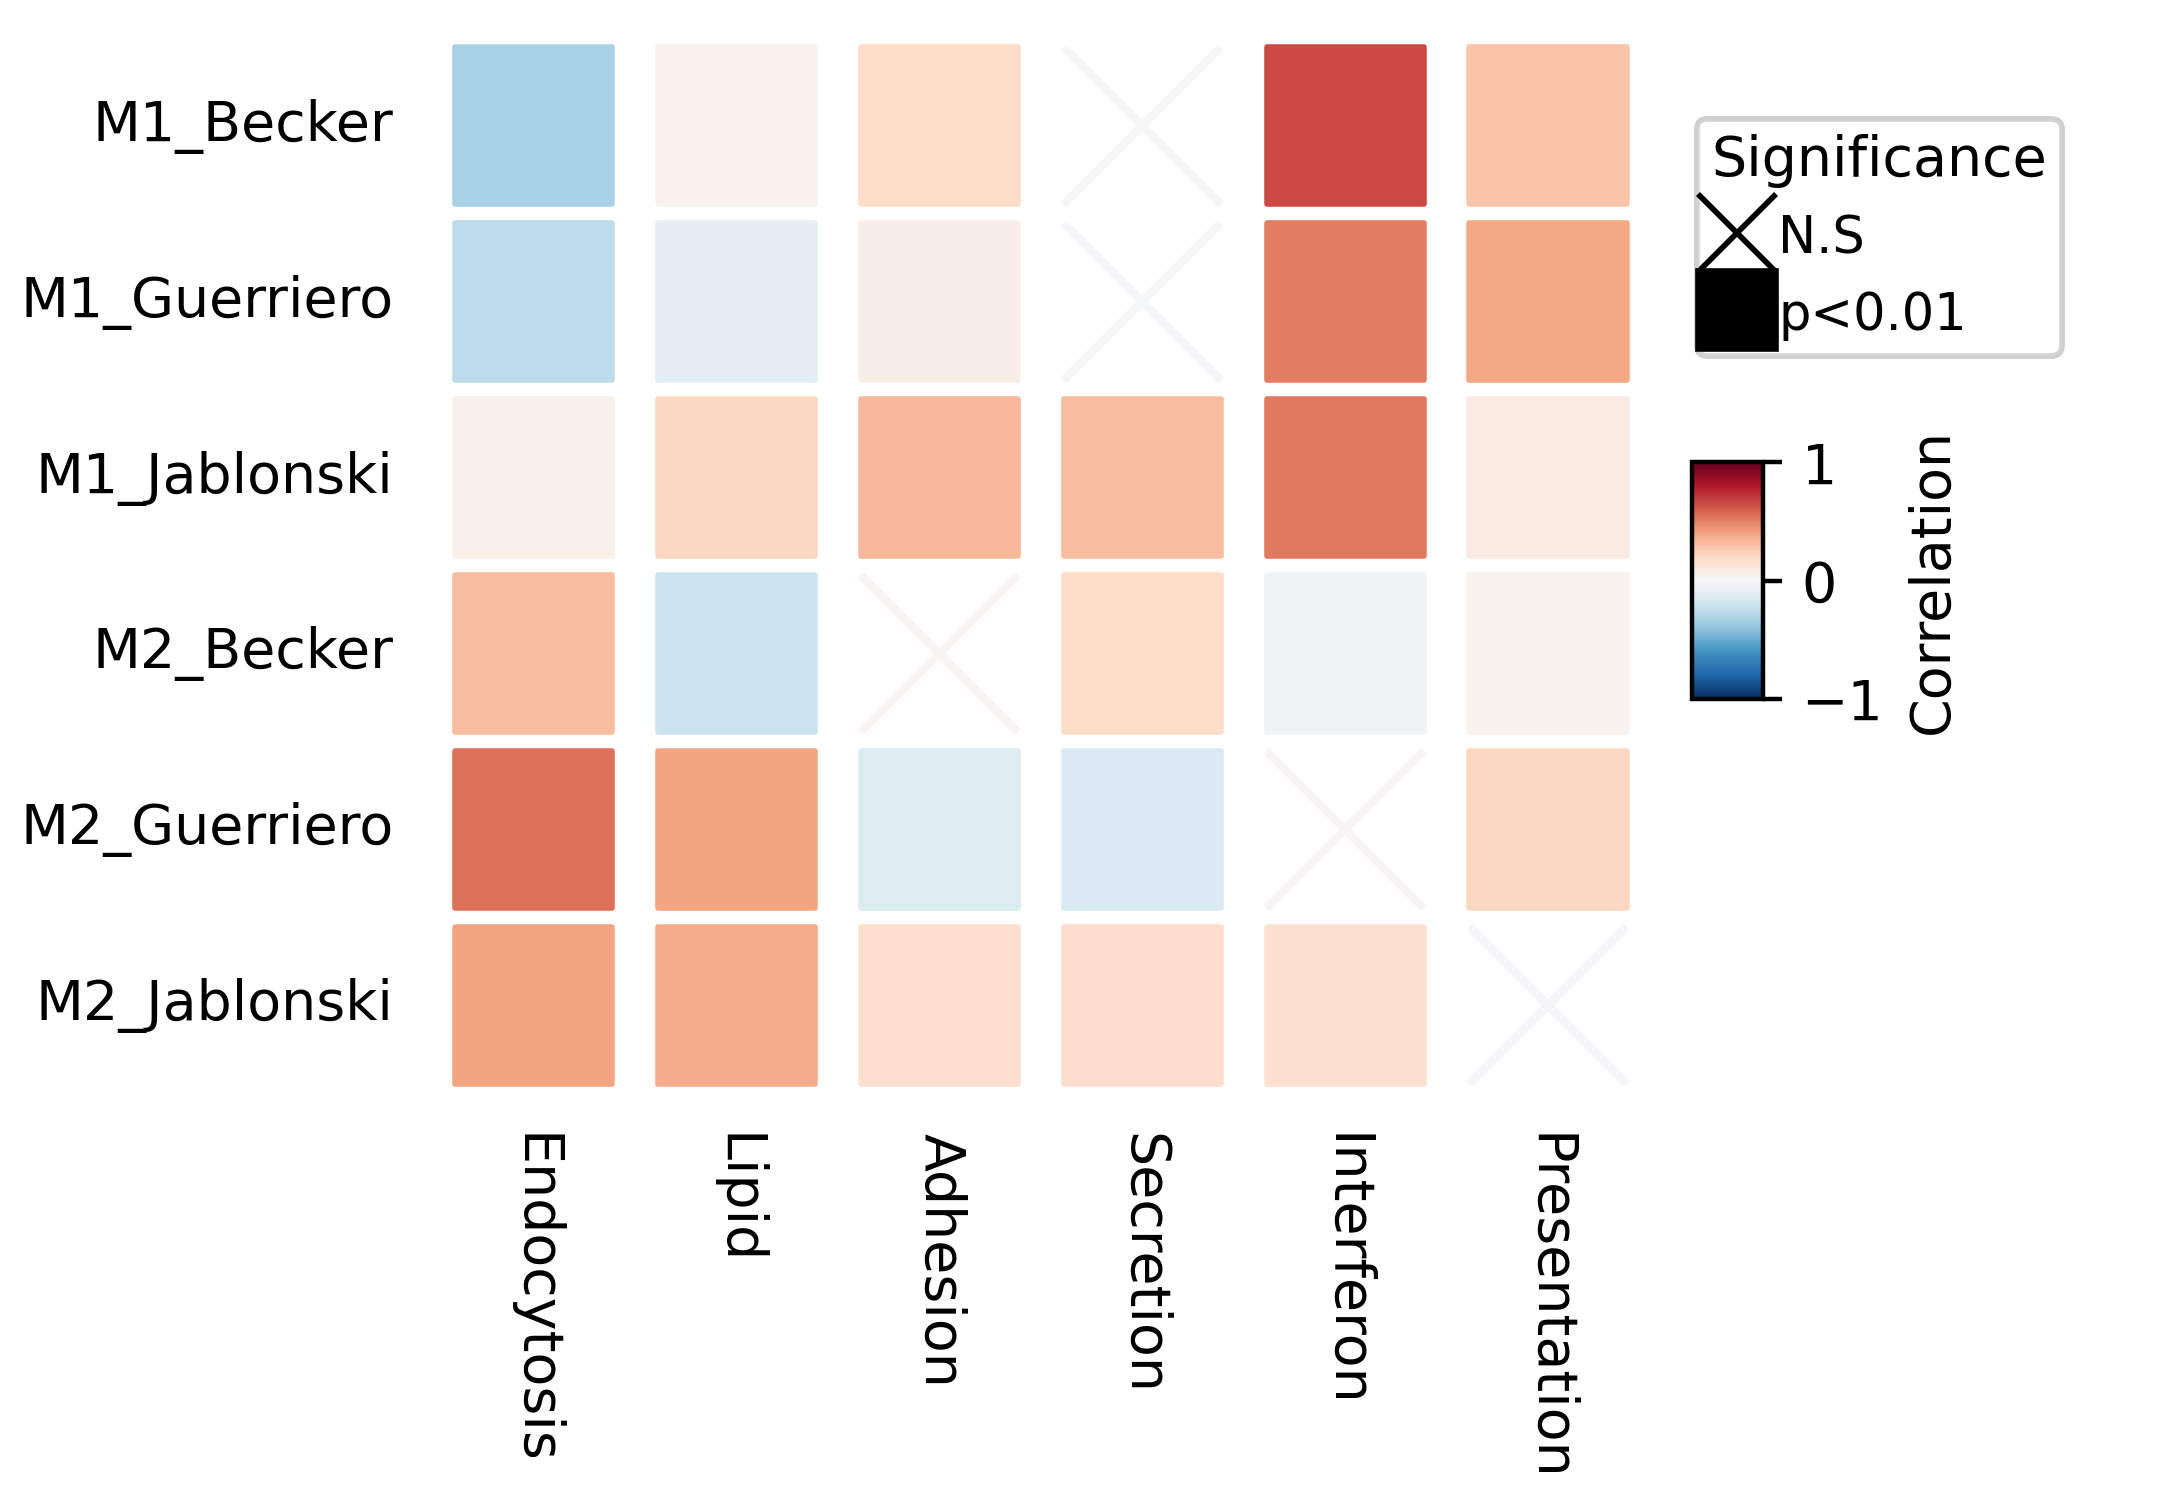

In [33]:
plt.figure(figsize=(4, 3))
plt.rcParams['axes.grid'] = False 
# col_ha = HeatmapAnnotation(label=anno_label(pd.Series(['Endocytosis','Lipid','Presentation','Interferon','Adhesion','Secretion'])))
cm = DotClustermapPlotter(data=data, x='level_1',y='level_0',value='Correlation',c='Correlation',hue='Significance',
                          s=4,
                          # top_annotation=col_ha,
                          # left_annotation=row_ha,
                          # col_split=pd.Series(order[:-1],index=order[:-1]),
                          # col_split_order = order[:-1],
                          # row_split=pd.Series(order[1:],index=order[1:]),
                          # row_split_order = order[1:],
                          marker={'N.S':'x','p<0.01':'s'},
                          vmax=1,vmin=-1,cmap='RdBu_r',
                          ratio=200,
                          row_cluster=False,col_cluster=True,
                          show_rownames=True,show_colnames=True,row_names_side='left')
plt.show()

# W3D1 Prediction power

In [34]:
MP_anno_map

{'MP1': 'Endocytosis',
 'MP4': 'Lipid',
 'MP7': 'Interferon',
 'MP6': 'Adhesion',
 'MP5': 'Secretion',
 'MP8': 'Presentation'}

In [35]:
x='BestResponse'
explored_z=None
random_var='Patient'
dt = scores.loc[scores.Timepoint.isin(['W3D1']),:].copy()
dt.groupby([x,'Treatment_Arm'])[random_var].nunique().rename('N_Pts').reset_index()
Y=list(MP_anno_map.keys())
# Y = ['MP1','MP7']

In [36]:
dt[x] = pd.Categorical(dt[x],['0-I','II-III'],ordered=True)
result = lmTest(dt=dt,Y=Y,x=x,Z=[],explored_z=explored_z,random_var=random_var)
significant_MP = result.Y[(result.Pvalue<0.05)&(result[f'log2FC'].abs()>.5)].unique().tolist()
result.Y =  result.Y.map(MP_anno_map)
result

,Ctrl,Experiment,Y,Coef,log2FC,Pvalue,FDR
0,0-I,II-III,Interferon,-0.694551,-0.754048,2.4025647620793187e-10,0.0
0,0-I,II-III,Presentation,-0.758005,-0.456058,0.09666201380750303,0.189998
0,0-I,II-III,Lipid,-0.33466,-0.04117,0.4464134691069792,0.446413
0,0-I,II-III,Adhesion,0.733965,0.13724,0.12028417416325006,0.189998
0,0-I,II-III,Secretion,0.342846,0.167658,0.1266654331574768,0.189998
0,0-I,II-III,Endocytosis,0.53644,1.176324,0.3106197409734719,0.372744


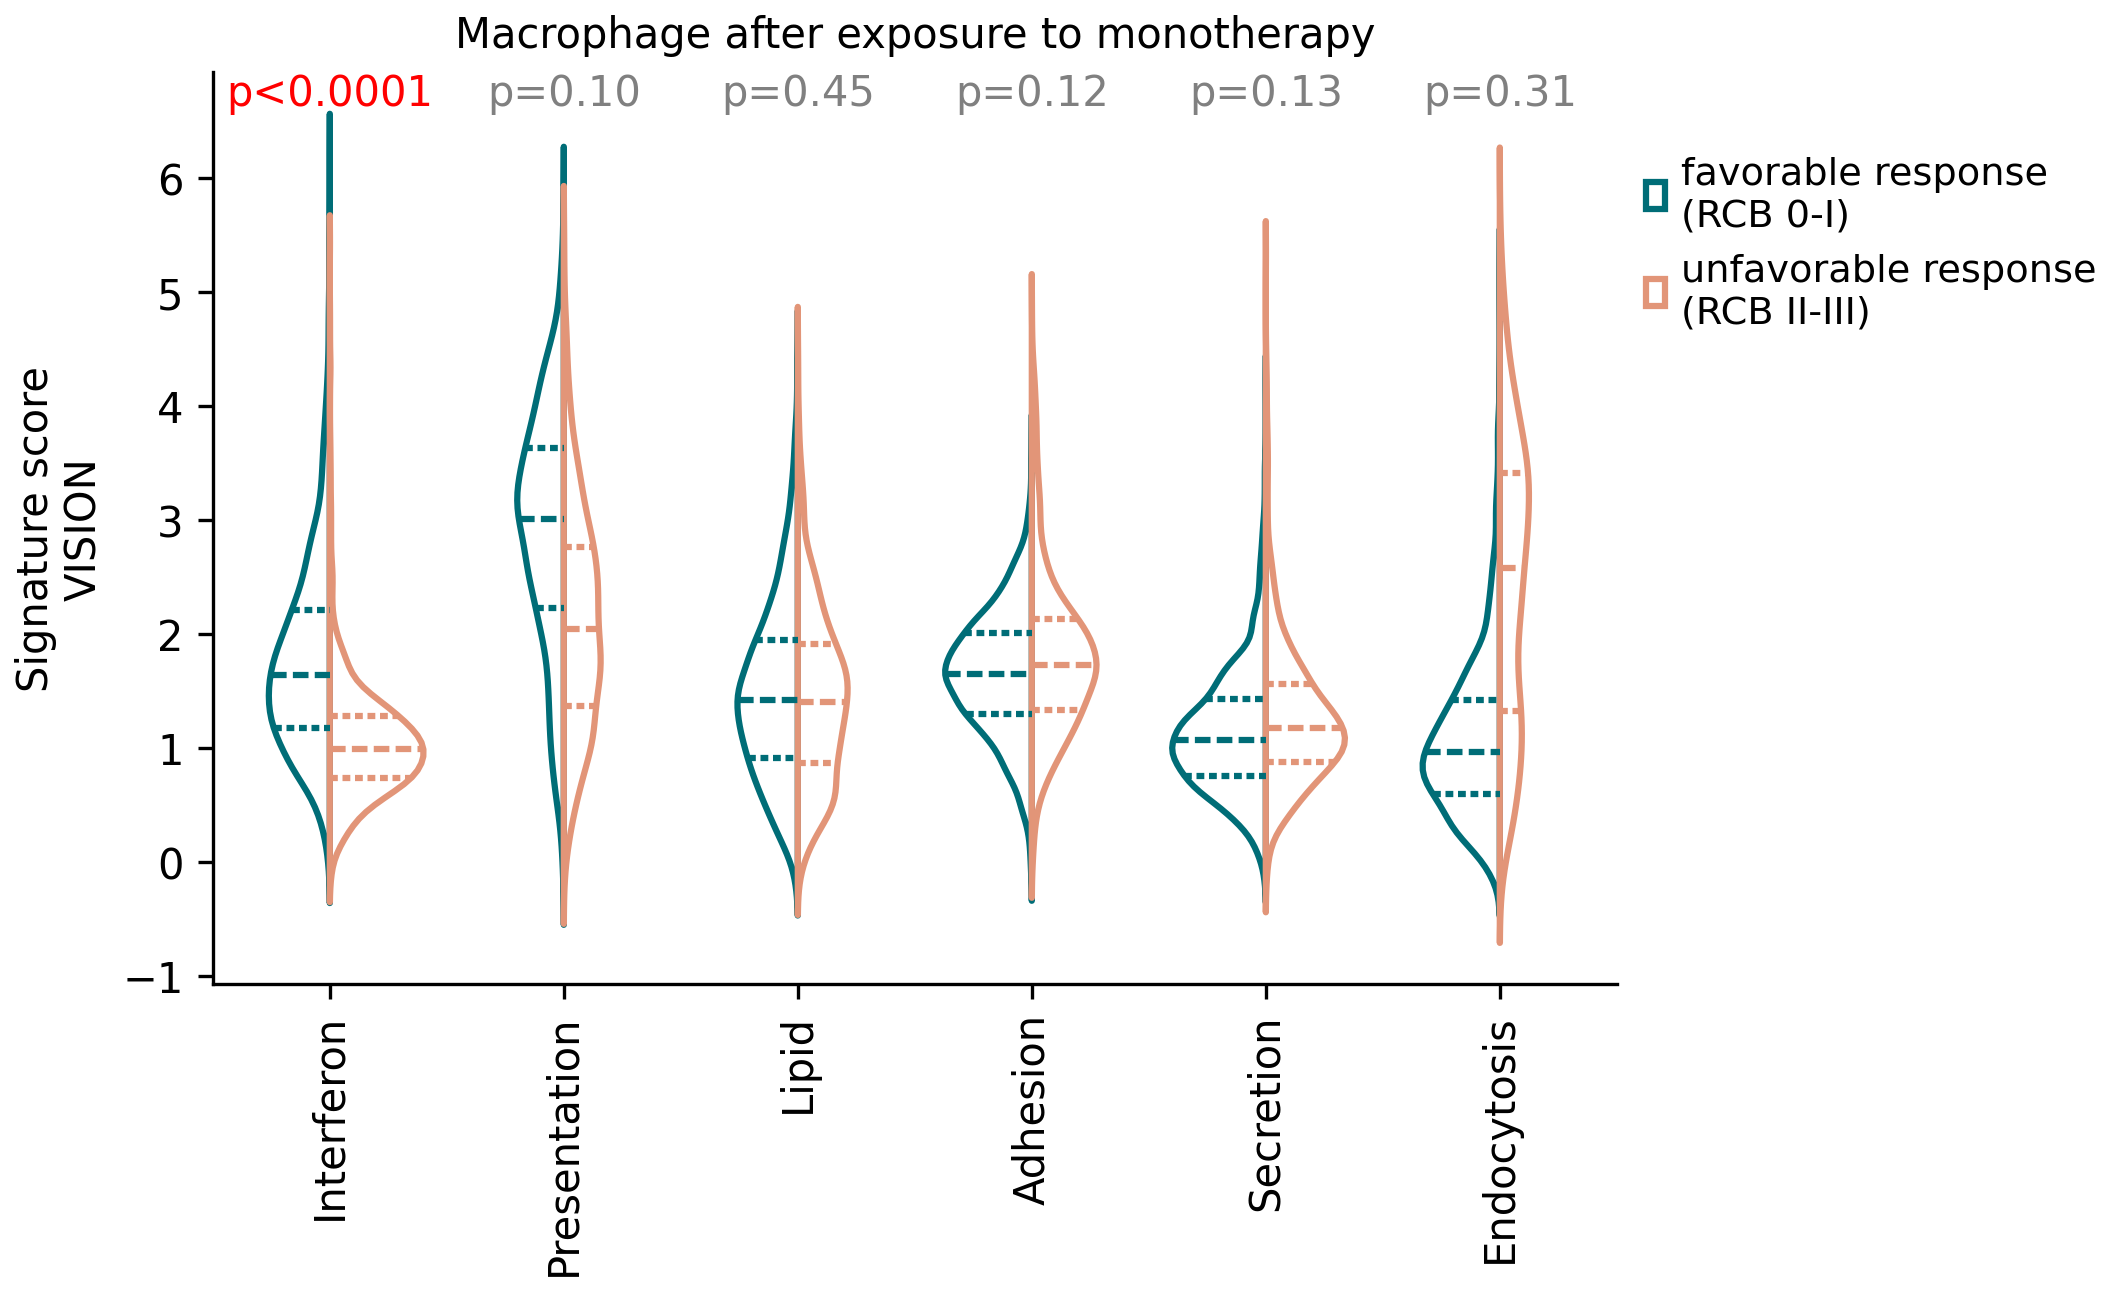

In [37]:
show_mps = result.sort_values('log2FC').Y.tolist() #['Lipid-associated','Interferon']
dt.rename(columns=MP_anno_map,inplace=True)
dt.BestResponse = dt.BestResponse.map({'0-I':'favorable response\n(RCB 0-I)','II-III':'unfavorable response\n(RCB II-III)'})
pvalues = result.loc[result.Y.isin(show_mps),:].set_index('Y')['Pvalue']
fig,ax=plt.subplots(1,1,dpi=150,figsize=(6,4))
sns.violinplot(data=dt[show_mps+[x]].melt(id_vars=[x]),
                   ax=ax,
                x='variable',y='value',hue=x,
                   # showfliers=False,
                split=True,inner="quart", fill=False,
                palette=COLOR_PAlETTE[x])
y_loc =ax.get_ylim()[1]
for xtick in ax.get_xticklabels():
    x_loc,_ = xtick.get_position()
    text = xtick.get_text()
    if pvalues[text] >= 0.05:
        c='gray'
        label = f"p={pvalues[text]:.2f}"
    elif pvalues[text] >= 0.0001:
        label = f"p={pvalues[text]:.3f}"
        c = 'red'
    else:
        label = f"p<0.0001"
        c = 'red'
    ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c,fontsize=10)
ax.grid(False)
ax.tick_params(axis='x',rotation=90)
n_pt_label = ','.join([ f"N({k})={v}"for k,v in dt.drop_duplicates([random_var])[x].value_counts().to_dict().items()])
ax.set(xlabel='',ylabel=f'Signature score\n{signature_method}',title=f'Macrophage after exposure to monotherapy')# [{n_pt_label}]')
ax.legend(loc=(1.01,.7),frameon=False,ncol=1)
ax.spines[['right','top']].set_visible(False)

# Baseline prediction power

In [38]:
x='BestResponse'
explored_z=None
random_var='Patient'
dt = scores.loc[scores.Timepoint.isin(['Baseline']),:].copy()
dt.groupby([x,'Treatment_Arm'])[random_var].nunique().rename('N_Pts').reset_index()
# Y=list(MP_anno_map.keys())
# Y = ['MP1','MP7']

,BestResponse,Treatment_Arm,N_Pts
0,0-I,Chemo->Combo,1
1,0-I,ICI->Combo,2
2,II-III,Chemo->Combo,3
3,II-III,ICI->Combo,6


In [39]:
dt.groupby(['RCB','Treatment_Arm'])[random_var].nunique().rename('N_Pts').reset_index()

,RCB,Treatment_Arm,N_Pts
0,0,Chemo->Combo,0
1,0,ICI->Combo,1
2,I,Chemo->Combo,1
3,I,ICI->Combo,1
4,II,Chemo->Combo,2
5,II,ICI->Combo,3
6,III,Chemo->Combo,1
7,III,ICI->Combo,3


In [40]:
dt[x] = pd.Categorical(dt[x],['0-I','II-III'],ordered=True)
result = lmTest(dt=dt,Y=Y,x=x,Z=[],explored_z=explored_z,random_var=random_var)
significant_MP = result.Y[(result.Pvalue<0.05)&(result[f'log2FC'].abs()>.5)].unique().tolist()
result.Y =  result.Y.map(MP_anno_map)
# result = result.loc[result.Treatment_Arm.str.contains('\+'),:].sort_values('log2FC')
result

,Ctrl,Experiment,Y,Coef,log2FC,Pvalue,FDR
0,0-I,II-III,Interferon,-0.337669,-0.175024,0.11706997547089476,0.35121
0,0-I,II-III,Presentation,-0.151111,-0.063709,0.725689583826627,0.870828
0,0-I,II-III,Adhesion,0.20868,0.065683,0.11285184005851256,0.35121
0,0-I,II-III,Secretion,0.012507,0.142633,0.9539976946947102,0.953998
0,0-I,II-III,Endocytosis,-0.260929,0.214124,0.4869779682814681,0.870828
0,0-I,II-III,Lipid,0.162073,0.349388,0.6814857020954929,0.870828


In [41]:
result.sort_values('log2FC')

,Ctrl,Experiment,Y,Coef,log2FC,Pvalue,FDR
0,0-I,II-III,Interferon,-0.337669,-0.175024,0.11706997547089476,0.35121
0,0-I,II-III,Presentation,-0.151111,-0.063709,0.725689583826627,0.870828
0,0-I,II-III,Adhesion,0.20868,0.065683,0.11285184005851256,0.35121
0,0-I,II-III,Secretion,0.012507,0.142633,0.9539976946947102,0.953998
0,0-I,II-III,Endocytosis,-0.260929,0.214124,0.4869779682814681,0.870828
0,0-I,II-III,Lipid,0.162073,0.349388,0.6814857020954929,0.870828


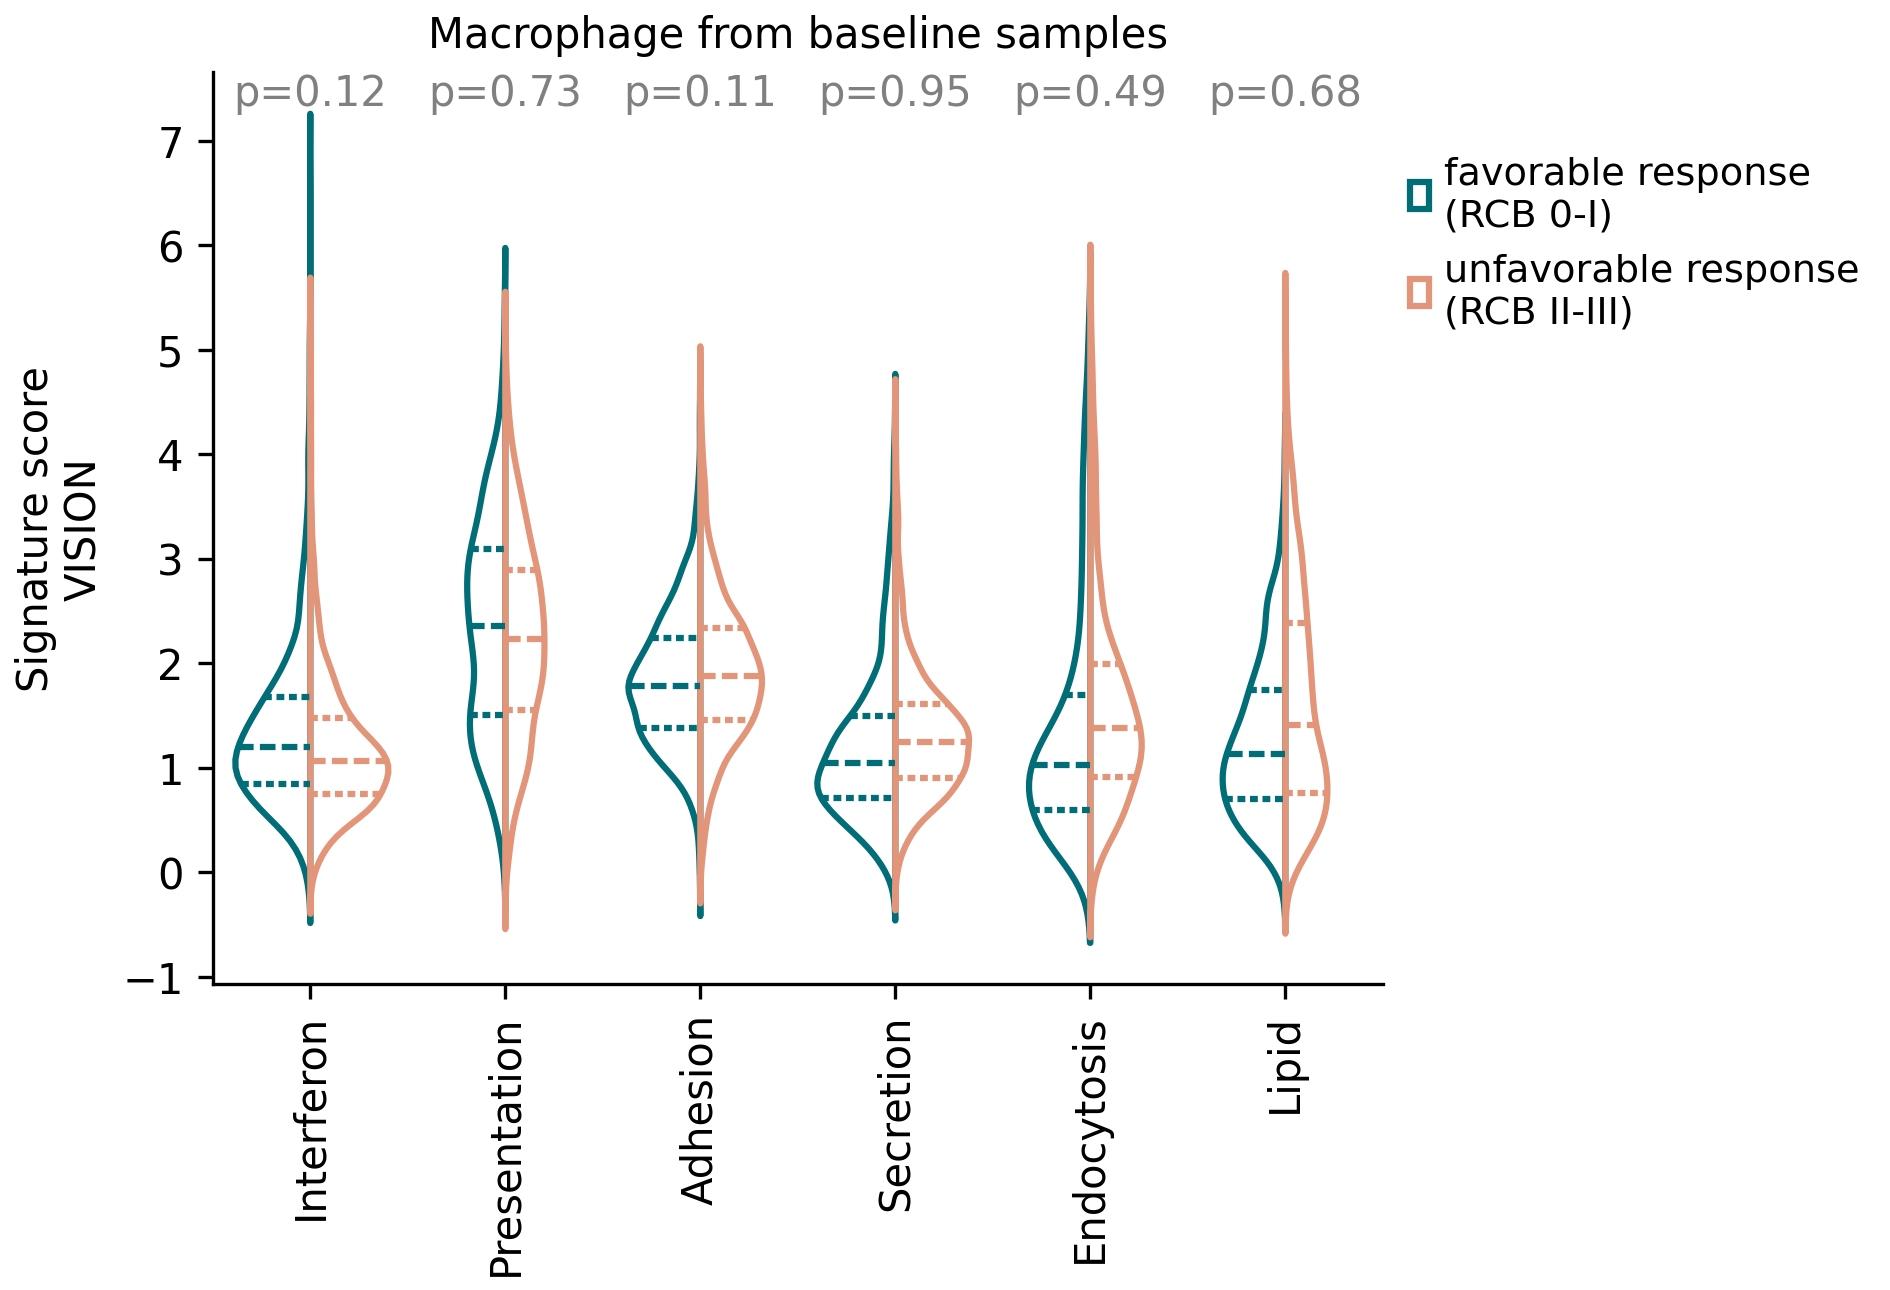

In [42]:
# show_mps = ['MES/Glycolysis','Proteasomal-degradation']
show_mps = result.sort_values('log2FC').Y.tolist() #['Lipid-associated','Interferon']
dt.rename(columns=MP_anno_map,inplace=True)
dt.BestResponse = dt.BestResponse.map({'0-I':'favorable response\n(RCB 0-I)','II-III':'unfavorable response\n(RCB II-III)'})
pvalues = result.loc[result.Y.isin(show_mps),:].set_index('Y')['Pvalue']
fig,ax=plt.subplots(1,1,dpi=150,figsize=(5,4))
sns.violinplot(data=dt[show_mps+[x]].melt(id_vars=[x]),
                   ax=ax,
                x='variable',y='value',hue=x,
                   # showfliers=False,
                split=True,inner="quart", fill=False,
                palette=COLOR_PAlETTE[x])
y_loc =ax.get_ylim()[1]
for xtick in ax.get_xticklabels():
    x_loc,_ = xtick.get_position()
    text = xtick.get_text()
    if pvalues[text] >= 0.05:
        c='gray'
        label = f"p={pvalues[text]:.2f}"
    else:
        label = f"p={pvalues[text]:.3f}"
        c = 'red'
    ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c,fontsize=10)
ax.tick_params(axis='x',rotation=90)
n_pt_label = ','.join([ f"N({k})={v}"for k,v in dt.drop_duplicates([random_var])[x].value_counts().to_dict().items()])
ax.set(xlabel='',ylabel=f'Signature score\n{signature_method}',title=f'Macrophage from baseline samples')# [{n_pt_label}]')
ax.legend(loc=(1.01,.7),frameon=False,ncol=1)
ax.spines[['right','top']].set_visible(False)

# Theray induced changes 

In [45]:
results = {}
random_var='Patient'

## Chemotherapy

In [46]:
x='Timepoint'
explored_z=None
random_var='Patient'
dt = scores.loc[(scores.Timepoint.isin(['Baseline','W3D1']))&
                (scores.Treatment_Arm=='Chemo->Combo'),:].copy()
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
dt.groupby([x])[random_var].nunique().rename('N_Pts').reset_index()

,Timepoint,N_Pts
0,AfterSurg,0
1,Baseline,2
2,Surg+AC,0
3,W3D1,2
4,W7D1,0


In [47]:
dt[x] = pd.Categorical(dt[x],['Baseline','W3D1'],ordered=True)
result = lmTest(dt=dt,Y=Y,x=x,Z=[],explored_z=explored_z,random_var=random_var)
result.Y =  result.Y.map(MP_anno_map)
results['Chemo'] = result
result

,Ctrl,Experiment,Y,Coef,log2FC,Pvalue,FDR
0,Baseline,W3D1,Adhesion,0.072379,0.039188,0.02762402810375548,0.033149
0,Baseline,W3D1,Lipid,0.060434,0.085525,0.11641185425605226,0.116412
0,Baseline,W3D1,Presentation,0.460073,0.261146,1.915679077935436e-25,0.0
0,Baseline,W3D1,Endocytosis,0.290022,0.322623,2.8833052966491813e-13,0.0
0,Baseline,W3D1,Interferon,0.387687,0.417662,1.1606160018116886e-27,0.0
0,Baseline,W3D1,Secretion,0.354123,0.418141,7.003148189045898e-38,0.0


## Pembro

In [48]:
x='Timepoint'
explored_z=None
random_var='Patient'
dt = scores.loc[(scores.Timepoint.isin(['Baseline','W3D1']))&
                (scores.Treatment_Arm=='ICI->Combo'),:].copy()
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
dt.groupby([x])[random_var].nunique().rename('N_Pts').reset_index()

,Timepoint,N_Pts
0,AfterSurg,0
1,Baseline,3
2,Surg+AC,0
3,W3D1,3
4,W7D1,0


In [49]:
dt[x] = pd.Categorical(dt[x],['Baseline','W3D1'],ordered=True)
result = lmTest(dt=dt,Y=Y,x=x,Z=[],explored_z=explored_z,random_var=random_var)
result.Y =  result.Y.map(MP_anno_map)
results['Pembro'] = result
result

,Ctrl,Experiment,Y,Coef,log2FC,Pvalue,FDR
0,Baseline,W3D1,Endocytosis,-0.259663,-0.420072,1.8276531412923458e-07,0.0
0,Baseline,W3D1,Lipid,-0.053036,-0.169441,0.24435031541307506,0.24435
0,Baseline,W3D1,Adhesion,0.120779,0.047046,0.045349890278479146,0.05442
0,Baseline,W3D1,Presentation,0.203133,0.193835,0.0064205360510128035,0.009631
0,Baseline,W3D1,Secretion,0.237331,0.204705,5.0679706314050747e-08,0.0
0,Baseline,W3D1,Interferon,0.285555,0.437299,1.7995854943891648e-10,0.0


### Adjuvant Combo

In [50]:
x='Timepoint'
explored_z=None
random_var='Patient'
dt = scores.loc[(scores.Timepoint.isin(['W3D1','W7D1'])),:].copy()
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
dt.groupby([x])[random_var].nunique().rename('N_Pts').reset_index()

,Timepoint,N_Pts
0,AfterSurg,0
1,Baseline,0
2,Surg+AC,0
3,W3D1,5
4,W7D1,5


In [51]:
dt[x] = pd.Categorical(dt[x],['W3D1','W7D1'],ordered=True)
result = lmTest(dt=dt,Y=Y,x=x,Z=[],explored_z=explored_z,random_var=random_var)
result.Y =  result.Y.map(MP_anno_map)
results['Combination'] = result
result

,Ctrl,Experiment,Y,Coef,log2FC,Pvalue,FDR
0,W3D1,W7D1,Adhesion,-0.367131,-0.273008,7.753807287659437e-70,0.0
0,W3D1,W7D1,Secretion,-0.133226,-0.179905,1.3431207350817892e-11,0.0
0,W3D1,W7D1,Interferon,-0.194154,-0.178867,2.6109823711903668e-12,0.0
0,W3D1,W7D1,Presentation,-0.080035,0.060324,0.022196809631160223,0.022197
0,W3D1,W7D1,Endocytosis,0.179877,0.256432,1.6775493064868365e-11,0.0
0,W3D1,W7D1,Lipid,0.520906,0.656252,1.3803321537327749e-67,0.0


## Visualize the effect

In [52]:
dt = []
for k,v in results.items():
    tmp = v.copy()
    tmp['Comparison'] = k
    dt.append(tmp)
dt=pd.concat(dt,axis=0,ignore_index=True)
palette = {k.replace('Macs.',''):v for k,v in COLOR_PAlETTE['Cellstate'].items() if 'Macs' in k}
dt.head()

,Ctrl,Experiment,Y,Coef,log2FC,Pvalue,FDR,Comparison
0,Baseline,W3D1,Adhesion,0.072379,0.039188,0.02762402810375548,0.033149,Chemo
1,Baseline,W3D1,Lipid,0.060434,0.085525,0.11641185425605226,0.116412,Chemo
2,Baseline,W3D1,Presentation,0.460073,0.261146,1.915679077935436e-25,0.0,Chemo
3,Baseline,W3D1,Endocytosis,0.290022,0.322623,2.8833052966491813e-13,0.0,Chemo
4,Baseline,W3D1,Interferon,0.387687,0.417662,1.1606160018116886e-27,0.0,Chemo


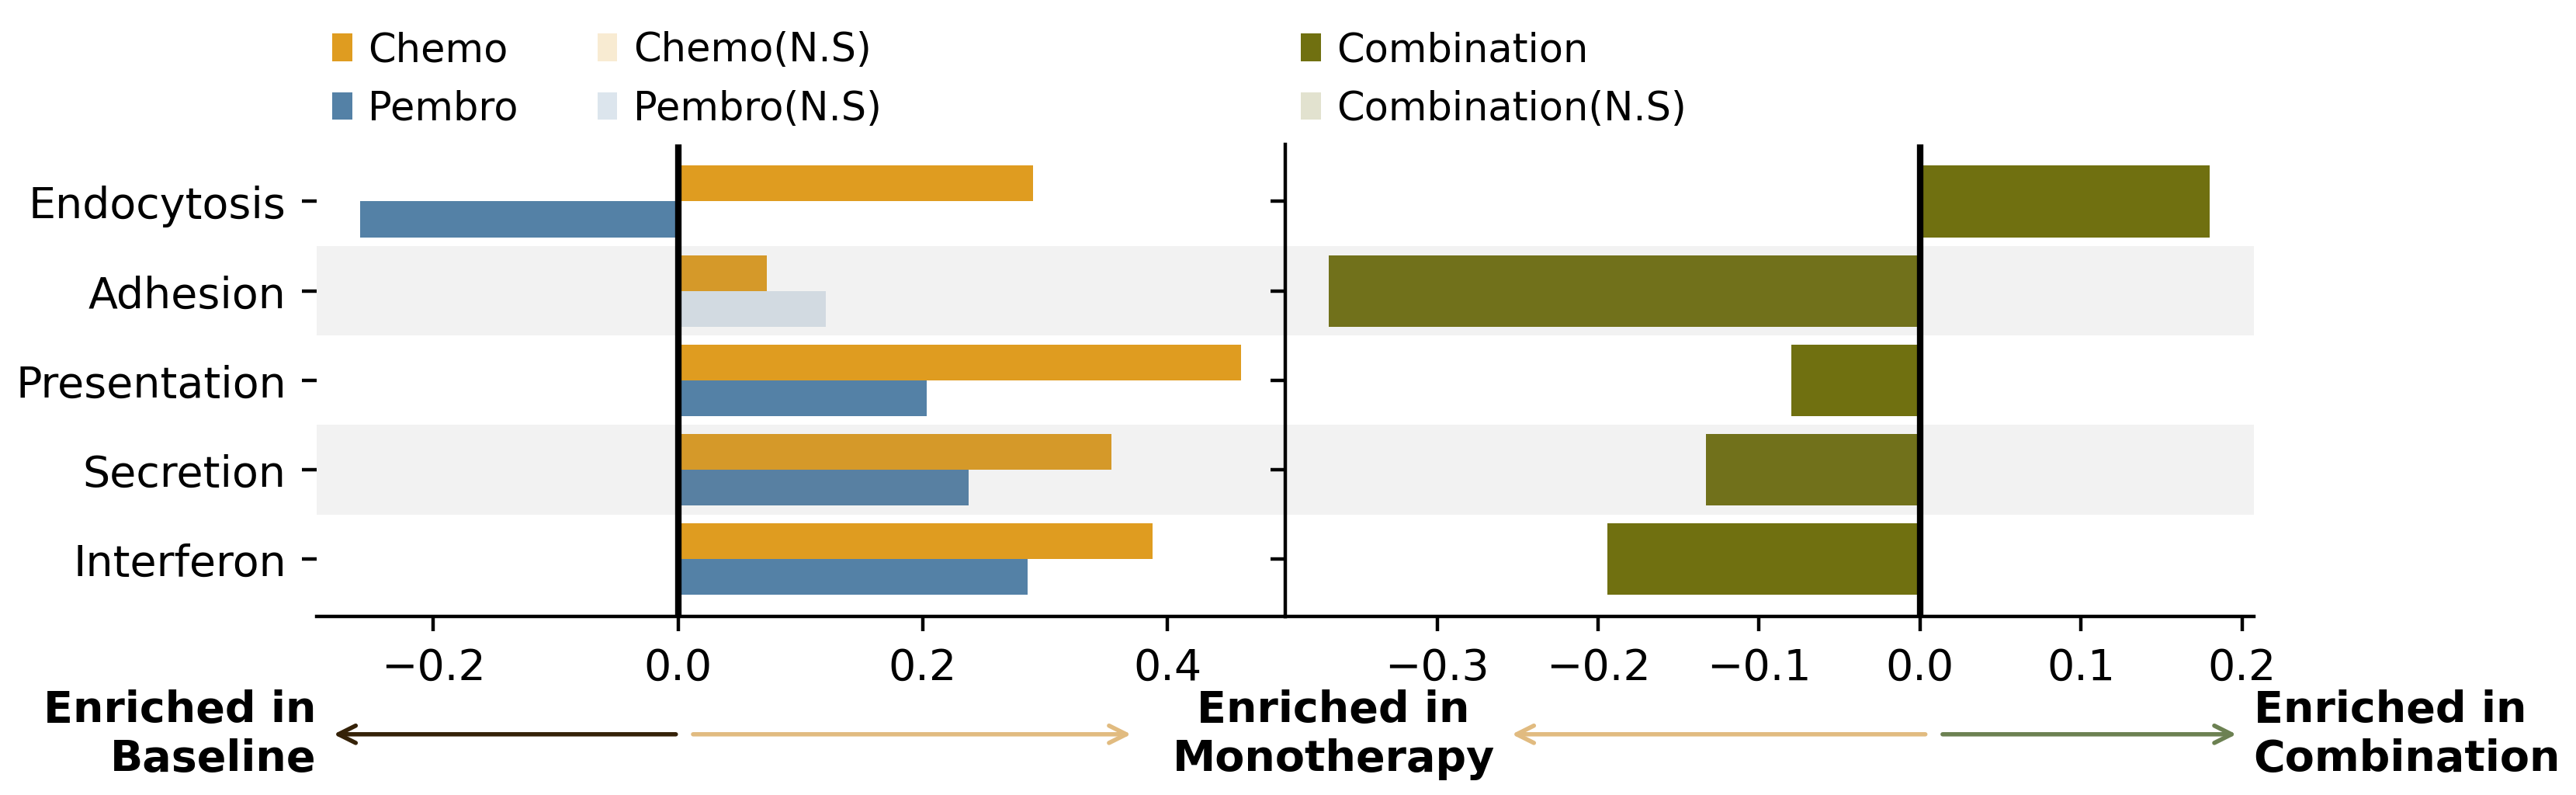

In [54]:
fig,axs=plt.subplots(1,2,figsize=(8,2),sharey=True,dpi=200)
ax =axs[0]
sig_y = dt.Y[dt.Comparison.isin(['Chemo','Pembro']) & (dt.FDR<0.05)].unique()
sub_dt = dt.loc[dt.Comparison.isin(['Chemo','Pembro']) & dt.Y.isin(sig_y),:].copy()
order = sub_dt.sort_values('Coef').Y

sns.barplot(data=sub_dt.loc[sub_dt['FDR']<0.05,:],x='Coef',y='Y',hue='Comparison',ax=ax,palette={'Chemo':'orange','Pembro':'steelblue'},order=order)

sub_dt.loc[sub_dt['FDR']<0.05,'Coef']=0
sub_dt['non_sig'] = sub_dt['Comparison']+"(N.S)"
sns.barplot(data=sub_dt,x='Coef',y='Y',hue='non_sig',ax=ax,palette={'Chemo(N.S)':'orange','Pembro(N.S)':'steelblue'},order=order,alpha=.2)
ax.legend(loc=(0,1),ncols=2)

ax.set(ylabel='',xlabel='')#Coefficient: W3D1-Baseline')
ax.grid(False)
ax.axvline(x=0,color='k')
ax.spines['left'].set_visible(False)
center=.38
name =''
ax.annotate(name, xy=(center, -0.25), xycoords='axes fraction', xytext=(0.85, -0.25), 
            arrowprops=dict(arrowstyle="<-", color=COLOR_PAlETTE['Timepoint']['W3D1']),ha='center',va='center')
name ='Enriched in\nBaseline'
ax.annotate(name, xy=(center, -0.25), xycoords='axes fraction', xytext=(0, -0.25), 
            arrowprops=dict(arrowstyle="<-",  color=COLOR_PAlETTE['Timepoint']['Baseline']),ha='right',va='center',weight='bold')
ax.axhspan(.5, 1.5, facecolor='gray', alpha=0.1)
ax.axhspan(2.5, 3.5, facecolor='gray', alpha=0.1)

ax =axs[1]
# sig_y = dt.Y[dt.Comparison.isin(['Combination']) & (dt.FDR<0.05)].unique()
sub_dt = dt.loc[dt.Comparison.isin(['Combination']) & dt.Y.isin(sig_y),:].copy()
sns.barplot(data=sub_dt.loc[sub_dt['FDR']<0.05,:],x='Coef',y='Y',ax=ax,color='olive',order=order,label='Combination')

sub_dt.loc[sub_dt['FDR']<0.05,'Coef']=0
sub_dt['non_sig'] = sub_dt['Comparison']+"(N.S)"
sns.barplot(data=sub_dt,x='Coef',y='Y',ax=ax,color='olive',order=order,alpha=.2,label='Combination(N.S)')

ax.legend(loc=(0,1),ncols=1)
ax.set(ylabel='',xlabel='')#Coefficient: W7D1-W3D1')
ax.grid(False)
# ax.spines['left'].set_visible(False)
ax.axvline(x=0,color='k')
plt.subplots_adjust(wspace=0)
center=.67
name ='Enriched in\nCombination'
ax.annotate(name, xy=(center, -0.25), xycoords='axes fraction', xytext=(1, -0.25), 
            arrowprops=dict(arrowstyle="<-", color=COLOR_PAlETTE['Timepoint']['W7D1']),ha='left',va='center',weight='bold')
name ='Enriched in\nMonotherapy'
ax.annotate(name, xy=(center, -0.25), xycoords='axes fraction', xytext=(0.05, -0.25), 
            arrowprops=dict(arrowstyle="<-",  color=COLOR_PAlETTE['Timepoint']['W3D1']),ha='center',va='center',weight='bold')

ax.axhspan(.5, 1.5, facecolor='gray', alpha=0.1)
ax.axhspan(2.5, 3.5, facecolor='gray', alpha=0.1)
# ax.axhspan(.5, 1.5, facecolor='gray', alpha=0.25)
plt.savefig(f"{FIGURE_FOLDER}/Macs_MPs_over_treatment.pdf",dpi=200)

# Paired patients - R vs NR

## All

In [63]:
x='Timepoint'
explored_z='Treatment_Arm'
random_var='Patient'
dt = scores.loc[scores.Timepoint.isin(['Baseline','W7D1']),:].copy()
# paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
# paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
dt.groupby([x,'Treatment_Arm'])[random_var].nunique().rename('N_Pts').reset_index()

,Timepoint,Treatment_Arm,N_Pts
0,AfterSurg,Chemo->Combo,0
1,AfterSurg,ICI->Combo,0
2,Baseline,Chemo->Combo,2
3,Baseline,ICI->Combo,3
4,Surg+AC,Chemo->Combo,0
5,Surg+AC,ICI->Combo,0
6,W3D1,Chemo->Combo,0
7,W3D1,ICI->Combo,0
8,W7D1,Chemo->Combo,2
9,W7D1,ICI->Combo,3


In [64]:
dt[x] = pd.Categorical(dt[x],['Baseline','W7D1'],ordered=True)
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[explored_z],explored_z=explored_z,random_var=random_var)
significant_MP = result.Y[(result.Pvalue<0.05)&(result[f'log2FC'].abs()>.5)].unique().tolist()
result.Y =  result.Y.map(MP_anno_map)
result = result.loc[result.Treatment_Arm.str.contains('\+'),:]
result

,Ctrl,Experiment,Y,Coef,log2FC,Pvalue,Treatment_Arm,FDR
0,Baseline,W7D1,Adhesion,-0.319331,-0.389403,2.367741273472699e-36,Chemo->Combo+ICI->Combo,0.0
0,Baseline,W7D1,Secretion,-0.02987,-0.303952,0.13215243488549286,Chemo->Combo+ICI->Combo,0.132152
0,Baseline,W7D1,Endocytosis,0.139809,-0.01171,3.9321961340758553e-07,Chemo->Combo+ICI->Combo,0.0
0,Baseline,W7D1,Presentation,0.257468,0.32471,1.642794138935683e-17,Chemo->Combo+ICI->Combo,0.0
0,Baseline,W7D1,Interferon,0.387257,0.429064,7.670500458454264e-59,Chemo->Combo+ICI->Combo,0.0
0,Baseline,W7D1,Lipid,0.79084,1.016346,2.7553802426432262e-176,Chemo->Combo+ICI->Combo,0.0


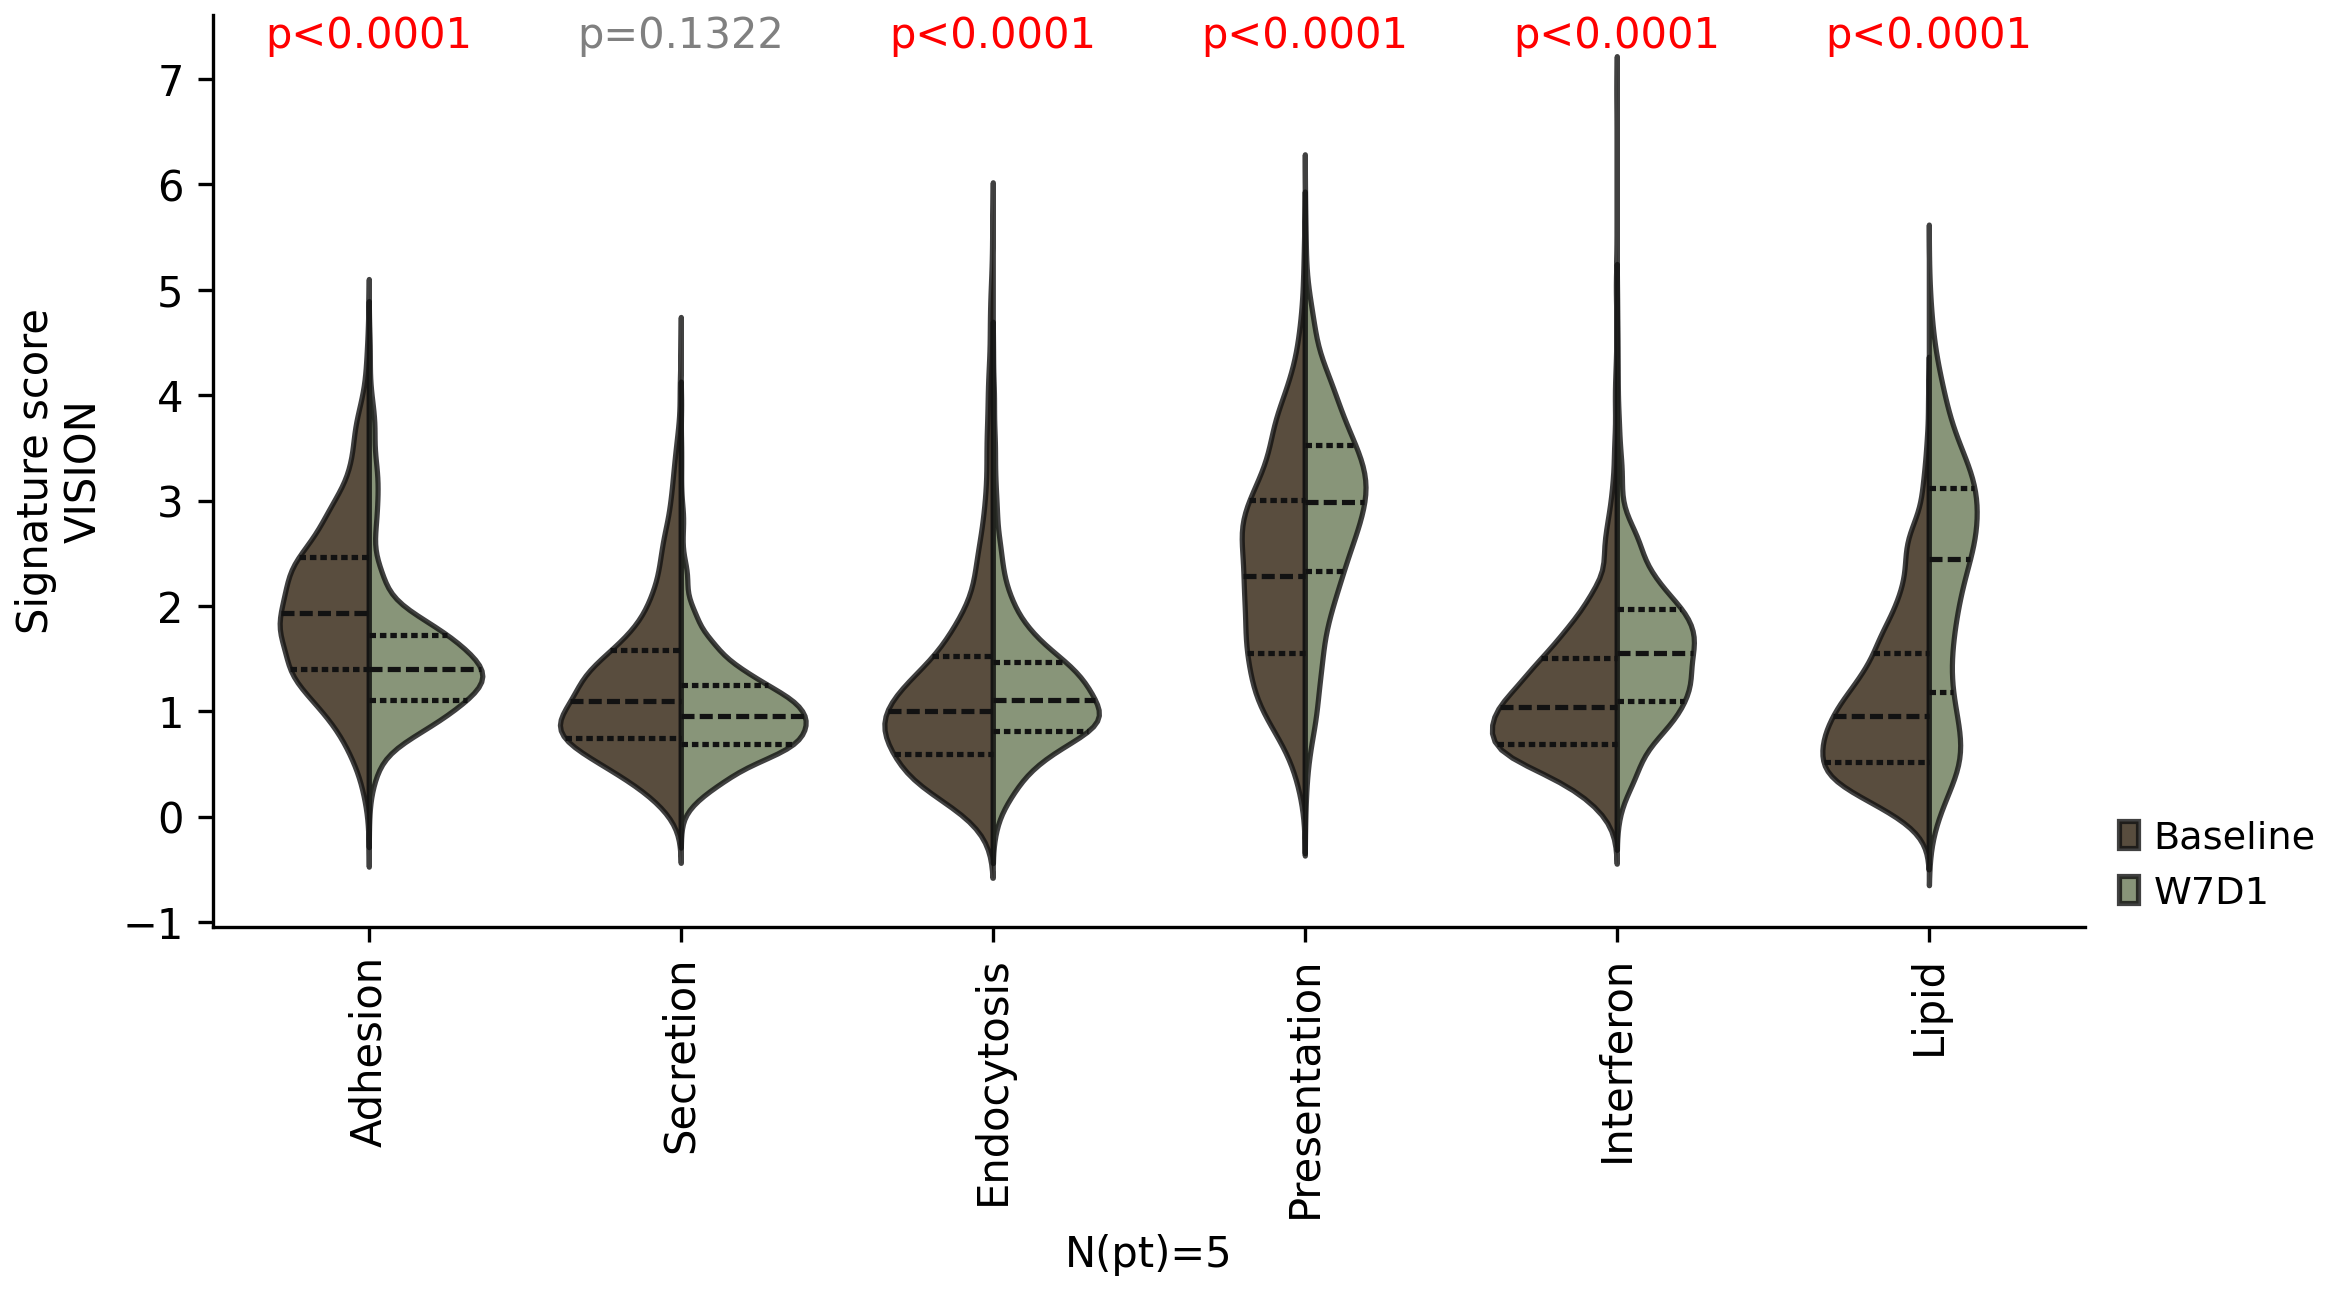

In [65]:
# show_mps = result.loc[(result.Pvalue<0.05)&(result[f'Coef'].abs()>.2),:].sort_values('log2FC').Y.tolist()
show_mps = result.sort_values('Coef').Y.unique().tolist()
pvalues = result.loc[(result.Y.isin(show_mps)),:].set_index('Y')['Pvalue']
dt.rename(columns=MP_anno_map,inplace=True)
fig,ax=plt.subplots(1,1,figsize=(8,4),dpi=150)
sns.violinplot(data=dt[show_mps+[x]].melt(id_vars=[x]),
                   ax=ax,
                x='variable',y='value',hue=x,
                   # showfliers=False,
                split=True,inner="quart", fill=True,
                palette=COLOR_PAlETTE[x],alpha=.8)
y_loc =ax.get_ylim()[1]
for xtick in ax.get_xticklabels():
    x_loc,_ = xtick.get_position()
    text = xtick.get_text()
    label = f"p={pvalues[text]:.4f}" if pvalues[text] >= 0.0001 else "p<0.0001"
    if pvalues[text] >= 0.05:
        c='gray'
    else:
        c = 'red'
    ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c)
ax.set(xlabel=f"N(pt)={dt['Patient'].nunique()}",ylabel=f"Signature score\n{signature_method}")
ax.legend(loc=(1.01,0),frameon=False,ncol=1)
ax.spines[['right','top']].set_visible(False);
ax.tick_params(axis='x',rotation=90)

# Changes W3D1 - W7D1

## Non-responder

In [76]:
x='Timepoint'
explored_z=None
random_var='Patient'
dt = scores.loc[scores.Timepoint.isin(['W3D1','W7D1'])&
                (scores.BestResponse=='II-III'),:].copy()
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
dt.groupby([x,'Treatment_Arm'])[random_var].nunique().rename('N_Pts').reset_index()

,Timepoint,Treatment_Arm,N_Pts
0,AfterSurg,Chemo->Combo,0
1,AfterSurg,ICI->Combo,0
2,Baseline,Chemo->Combo,0
3,Baseline,ICI->Combo,0
4,Surg+AC,Chemo->Combo,0
5,Surg+AC,ICI->Combo,0
6,W3D1,Chemo->Combo,1
7,W3D1,ICI->Combo,2
8,W7D1,Chemo->Combo,1
9,W7D1,ICI->Combo,2


In [77]:
dt[x] = pd.Categorical(dt[x],['W3D1','W7D1'],ordered=True)
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var)
significant_MP = result.Y[(result.Pvalue<0.05)&(result[f'log2FC'].abs()>.5)].unique().tolist()
result.Y =  result.Y.map(MP_anno_map)
# result = result.loc[result.Treatment_Arm.str.contains('\+'),:]

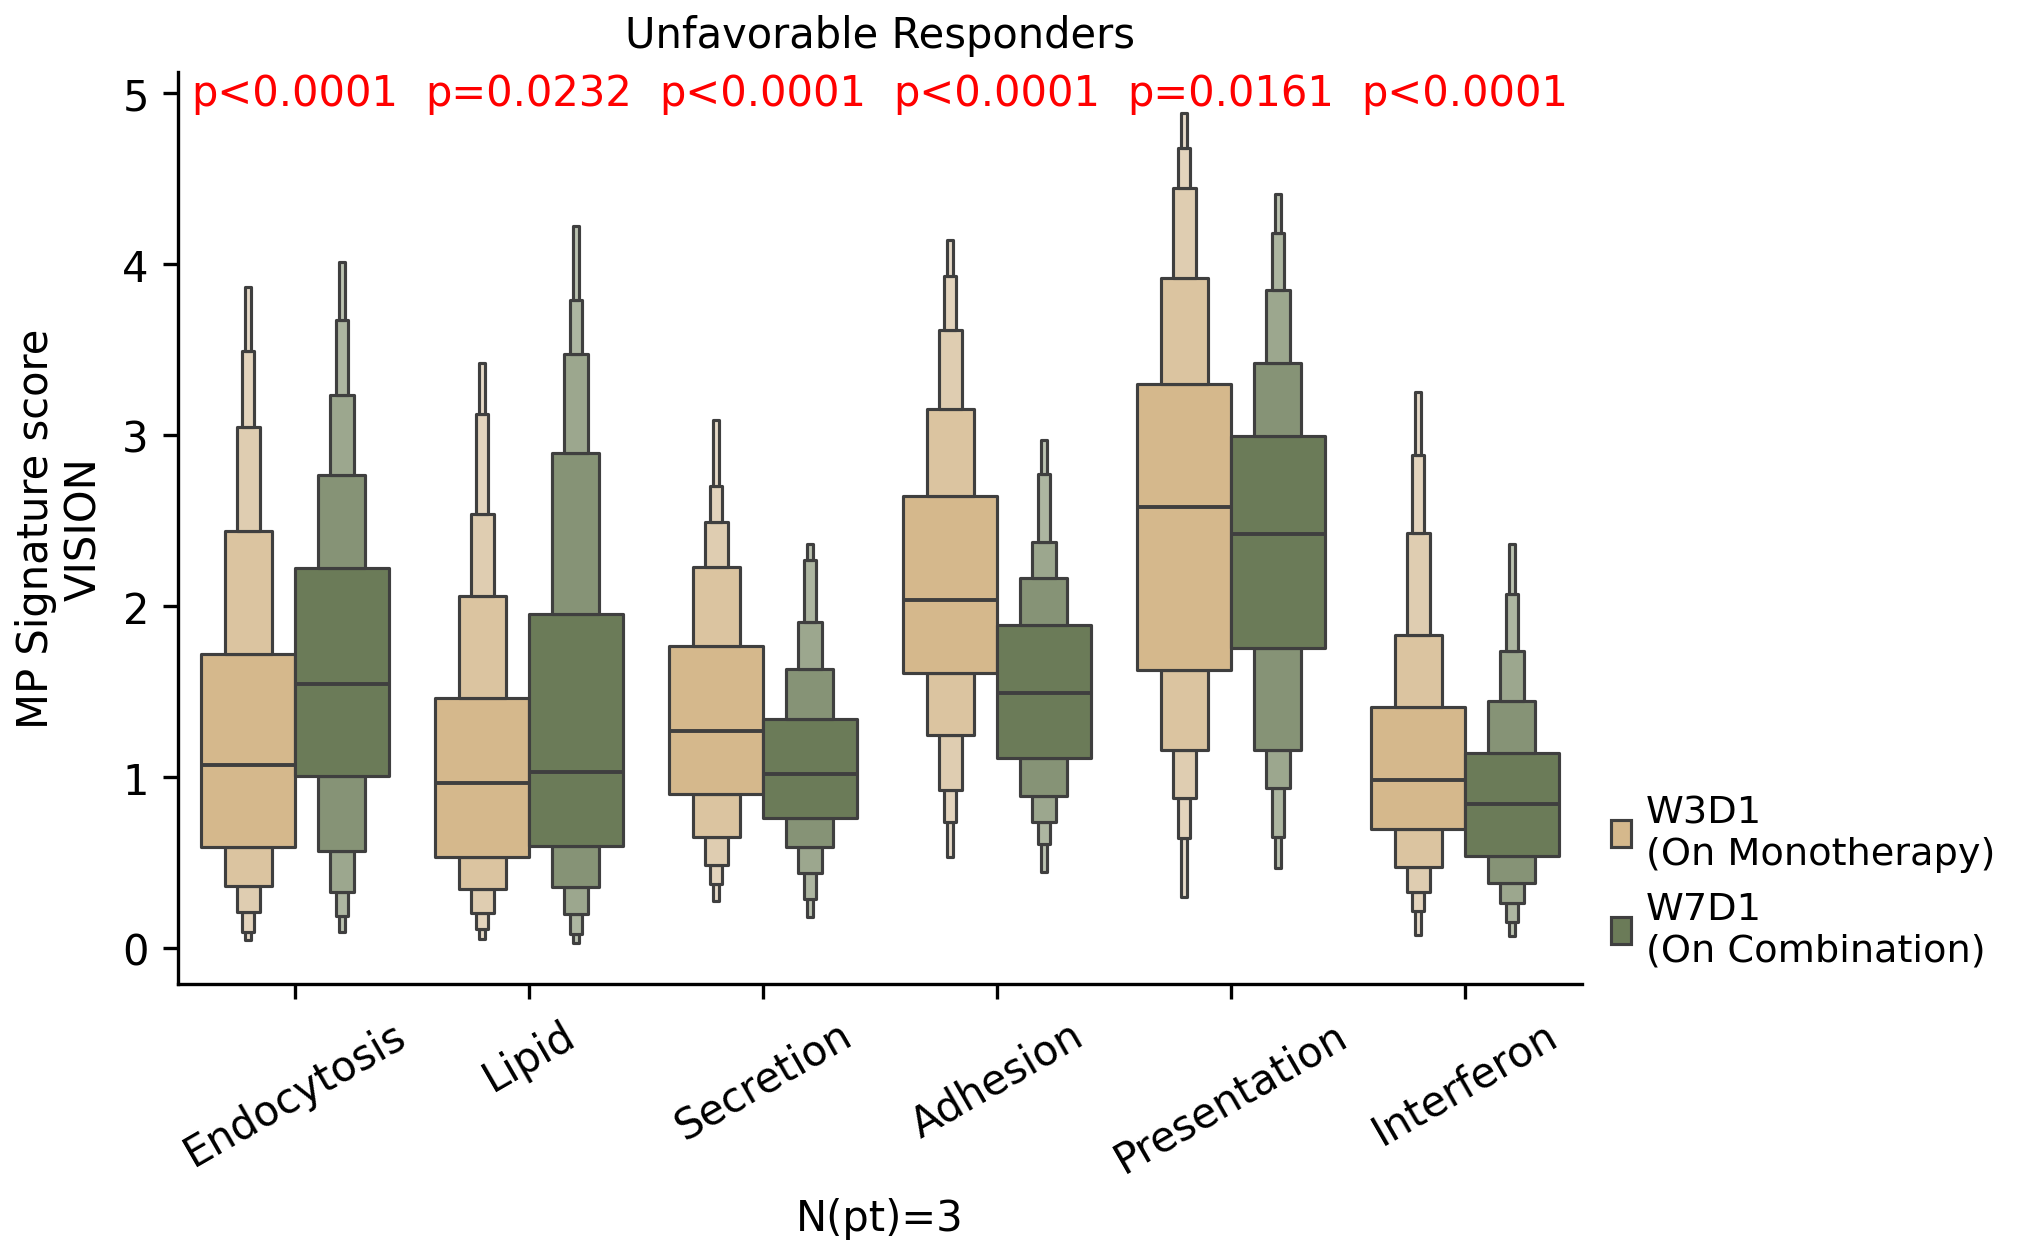

In [78]:
# show_mps = result.loc[(result.Pvalue<0.05)&(result[f'log2FC'].abs()>.5),:].sort_values('log2FC').Y.tolist()
# show_mps= ['Adhesion', 'Interferon', 'Lipid']
# show_mps = ['Endocytosis','Presentation']
# show_mps = list(MP_anno_map.values())
show_mps = ['Endocytosis','Lipid','Secretion','Adhesion','Presentation','Interferon'] # result.sort_values('Coef').Y.unique().tolist()
pvalues = result.loc[(result.Y.isin(show_mps)),:].set_index('Y')['Pvalue']
dt.rename(columns=MP_anno_map,inplace=True)
plot_rename = {'W3D1':'W3D1\n(On Monotherapy)','W7D1':'W7D1\n(On Combination)'}
dt[x] = dt[x].replace(plot_rename)
palette = {}
for k,v in plot_rename.items():
    palette[v] = COLOR_PAlETTE[x][k]
fig,ax=plt.subplots(1,1,figsize=(6,4),dpi=150)
sns.boxenplot(data=dt[show_mps+[x]].melt(id_vars=[x]),
                x='variable',y='value',hue=x,showfliers=False,
                palette=palette,ax=ax)
y_loc =ax.get_ylim()[1]
for xtick in ax.get_xticklabels():
    x_loc,_ = xtick.get_position()
    text = xtick.get_text()
    label = f"p={pvalues[text]:.4f}" if pvalues[text] >= 0.0001 else "p<0.0001"
    if pvalues[text] >= 0.05:
        c='gray'
    else:
        c = 'red'
    ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c)
ax.set(xlabel=f"N(pt)={dt['Patient'].nunique()}",ylabel=f"MP Signature score\n{signature_method}",title='Unfavorable Responders')
ax.legend(loc=(1.01,0),frameon=False,ncol=1)
ax.spines[['right','top']].set_visible(False);
ax.grid(False)
ax.tick_params(axis='x',rotation=30)

In [79]:
from scipy.stats import wilcoxon

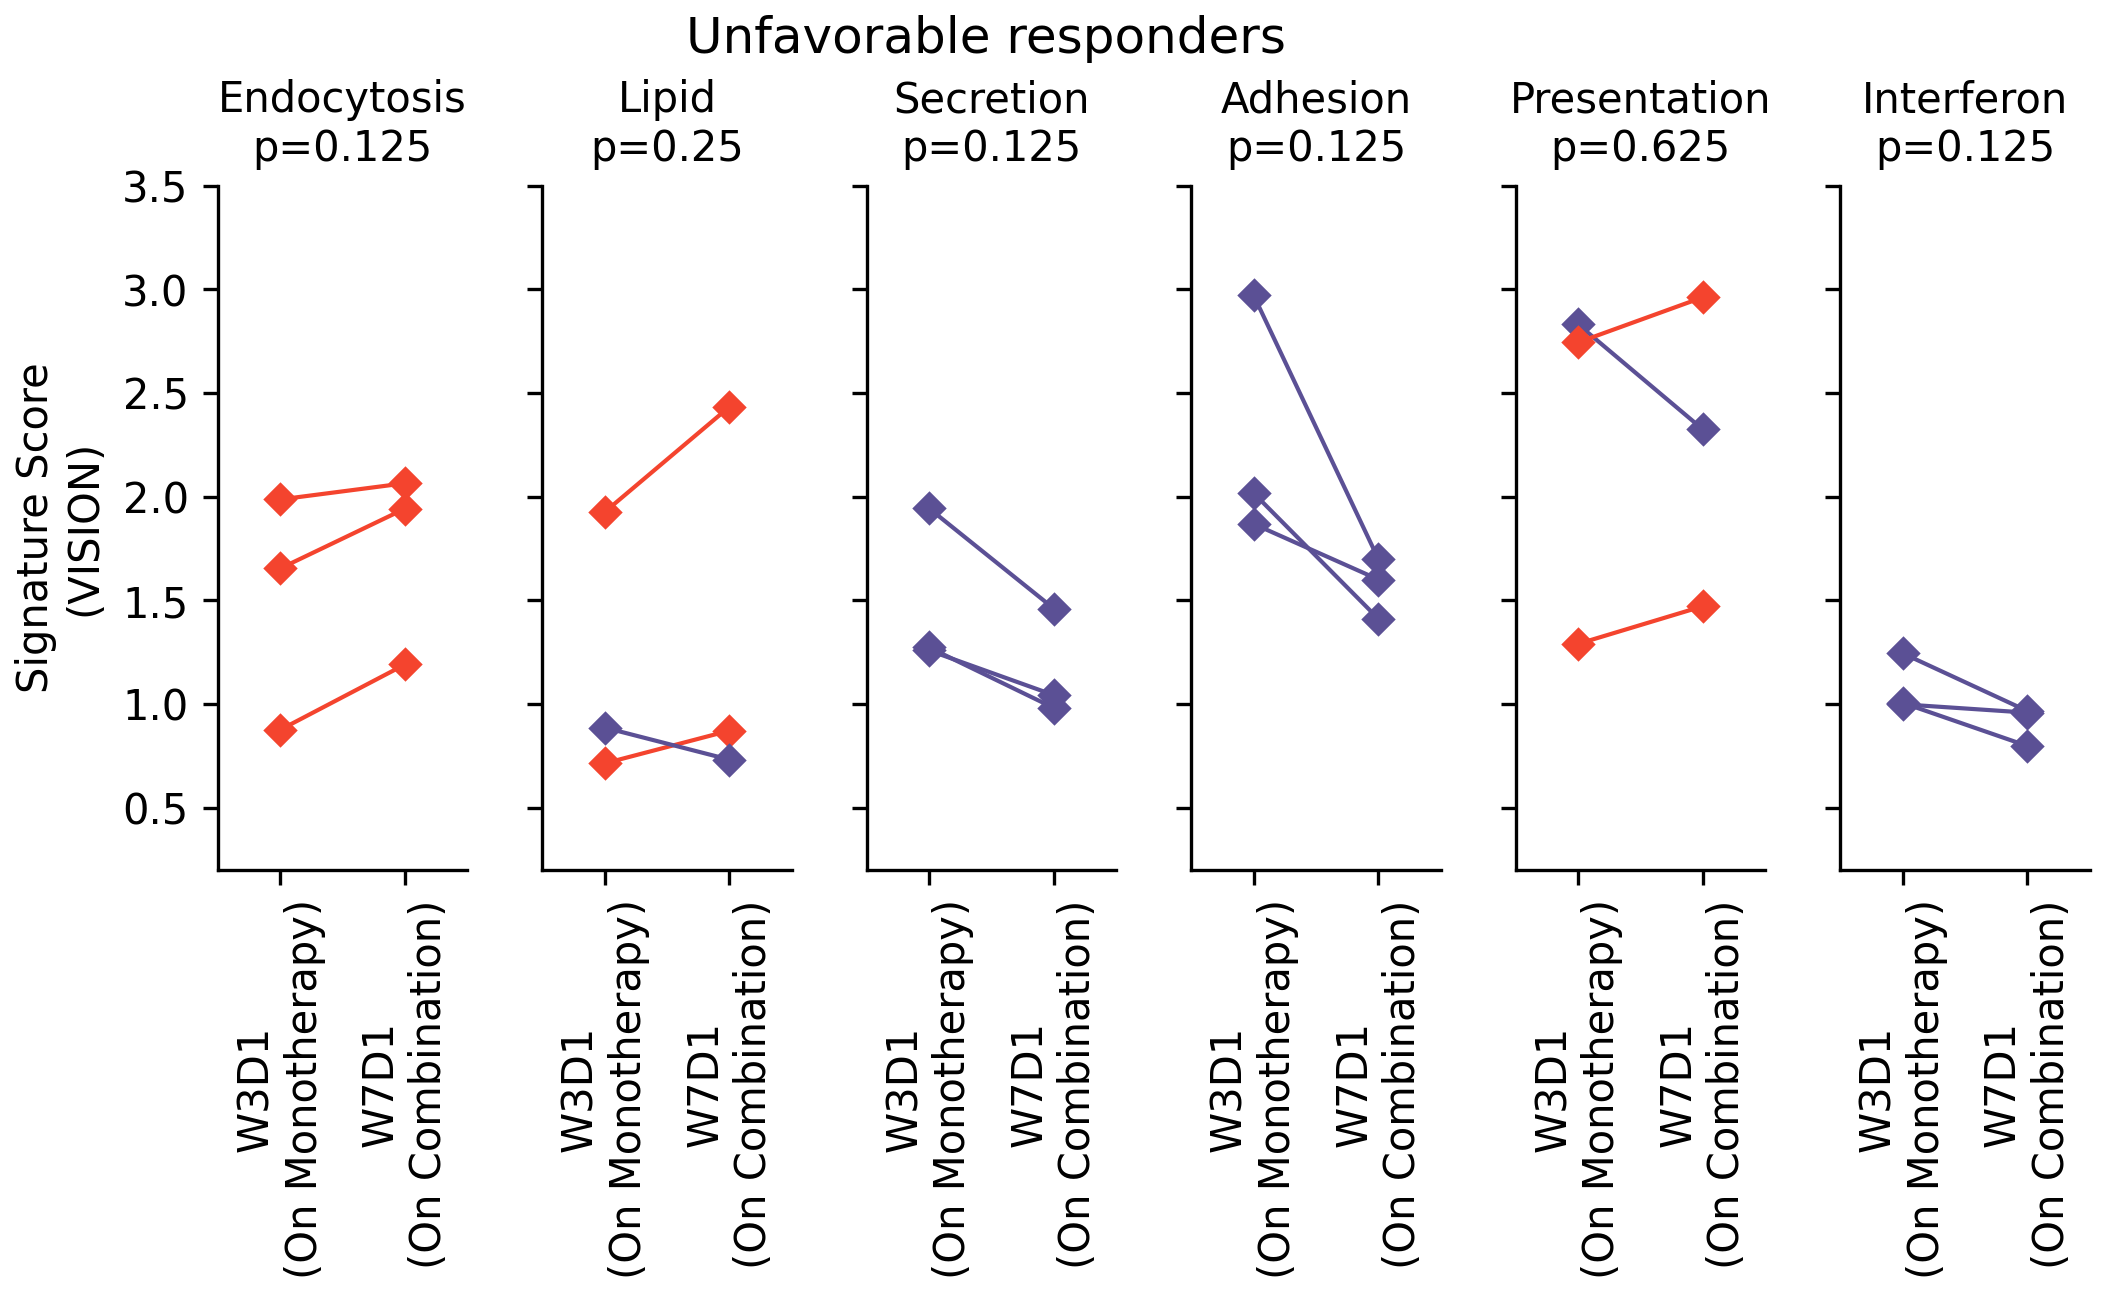

In [80]:
pseudo_dt = dt.groupby(['Patient','Timepoint'])[show_mps].mean().dropna(how='all',axis=0).reset_index()
pseudo_dt.Patient = pseudo_dt.Patient.astype(str)
fig,axs=plt.subplots(1,len(show_mps),figsize=(8,3),dpi=150,sharey=True)
for i,y in enumerate(show_mps):
    ax=axs[i]
    delta = pseudo_dt.pivot_table(index='Patient',columns='Timepoint',values=y).diff(axis=1)['W7D1\n(On Combination)']
    z,p = wilcoxon(delta.values,alternative='greater' if delta.sum()>0 else 'less')
    palette = delta.map(lambda x:"#f4442e" if x >0 else "#5b5095").to_dict()
    # palette = pseudo_dt[['Patient','BestResponse']].drop_duplicates().set_index('Patient')['BestResponse'].map(COLOR_PAlETTE['BestResponse']).to_dict()
    sns.pointplot(data=pseudo_dt,
                   ax=ax,
                  order=['W3D1\n(On Monotherapy)','W7D1\n(On Combination)'],
                  x='Timepoint',y=y,hue='Patient',
                  palette=palette,marker="D",markersize=5,linewidth=1)
    ax.set_ylim([.2,3.5])
    ax.legend_.remove()
    ax.set(xlabel='',ylabel='Signature Score\n(VISION)',title=f"{y}\np={p:.3}")
    ax.tick_params(axis='x',rotation=90)
    ax.grid(False)
plt.subplots_adjust(wspace=.3)
plt.suptitle('Unfavorable responders',y=1.1);

## In Responders

In [81]:
x='Timepoint'
explored_z=None
random_var='Patient'
dt = scores.loc[scores.Timepoint.isin(['W3D1','W7D1'])&
                (scores.BestResponse=='0-I'),:].copy()
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
dt.groupby([x,'Treatment_Arm'])[random_var].nunique().rename('N_Pts').reset_index()

,Timepoint,Treatment_Arm,N_Pts
0,AfterSurg,Chemo->Combo,0
1,AfterSurg,ICI->Combo,0
2,Baseline,Chemo->Combo,0
3,Baseline,ICI->Combo,0
4,Surg+AC,Chemo->Combo,0
5,Surg+AC,ICI->Combo,0
6,W3D1,Chemo->Combo,2
7,W3D1,ICI->Combo,0
8,W7D1,Chemo->Combo,2
9,W7D1,ICI->Combo,0


In [82]:
dt[x] = pd.Categorical(dt[x],['W3D1','W7D1'],ordered=True)
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var)
significant_MP = result.Y[(result.Pvalue<0.05)&(result[f'log2FC'].abs()>.5)].unique().tolist()
result.Y =  result.Y.map(MP_anno_map)
# result = result.loc[result.Treatment_Arm.str.contains('\+'),:]
result

,Ctrl,Experiment,Y,Coef,log2FC,Pvalue,FDR
0,W3D1,W7D1,Adhesion,-0.271218,-0.240613,2.221352676306014e-32,0.0
0,W3D1,W7D1,Secretion,-0.075918,-0.160385,0.0008263803620591804,0.000992
0,W3D1,W7D1,Interferon,-0.186187,-0.109646,2.5914205101226203e-08,0.0
0,W3D1,W7D1,Presentation,-0.050552,0.109748,0.22304841279354362,0.223048
0,W3D1,W7D1,Endocytosis,0.158216,0.19704,2.3347349496702187e-07,0.0
0,W3D1,W7D1,Lipid,0.674985,0.750968,1.0642411980965497e-78,0.0


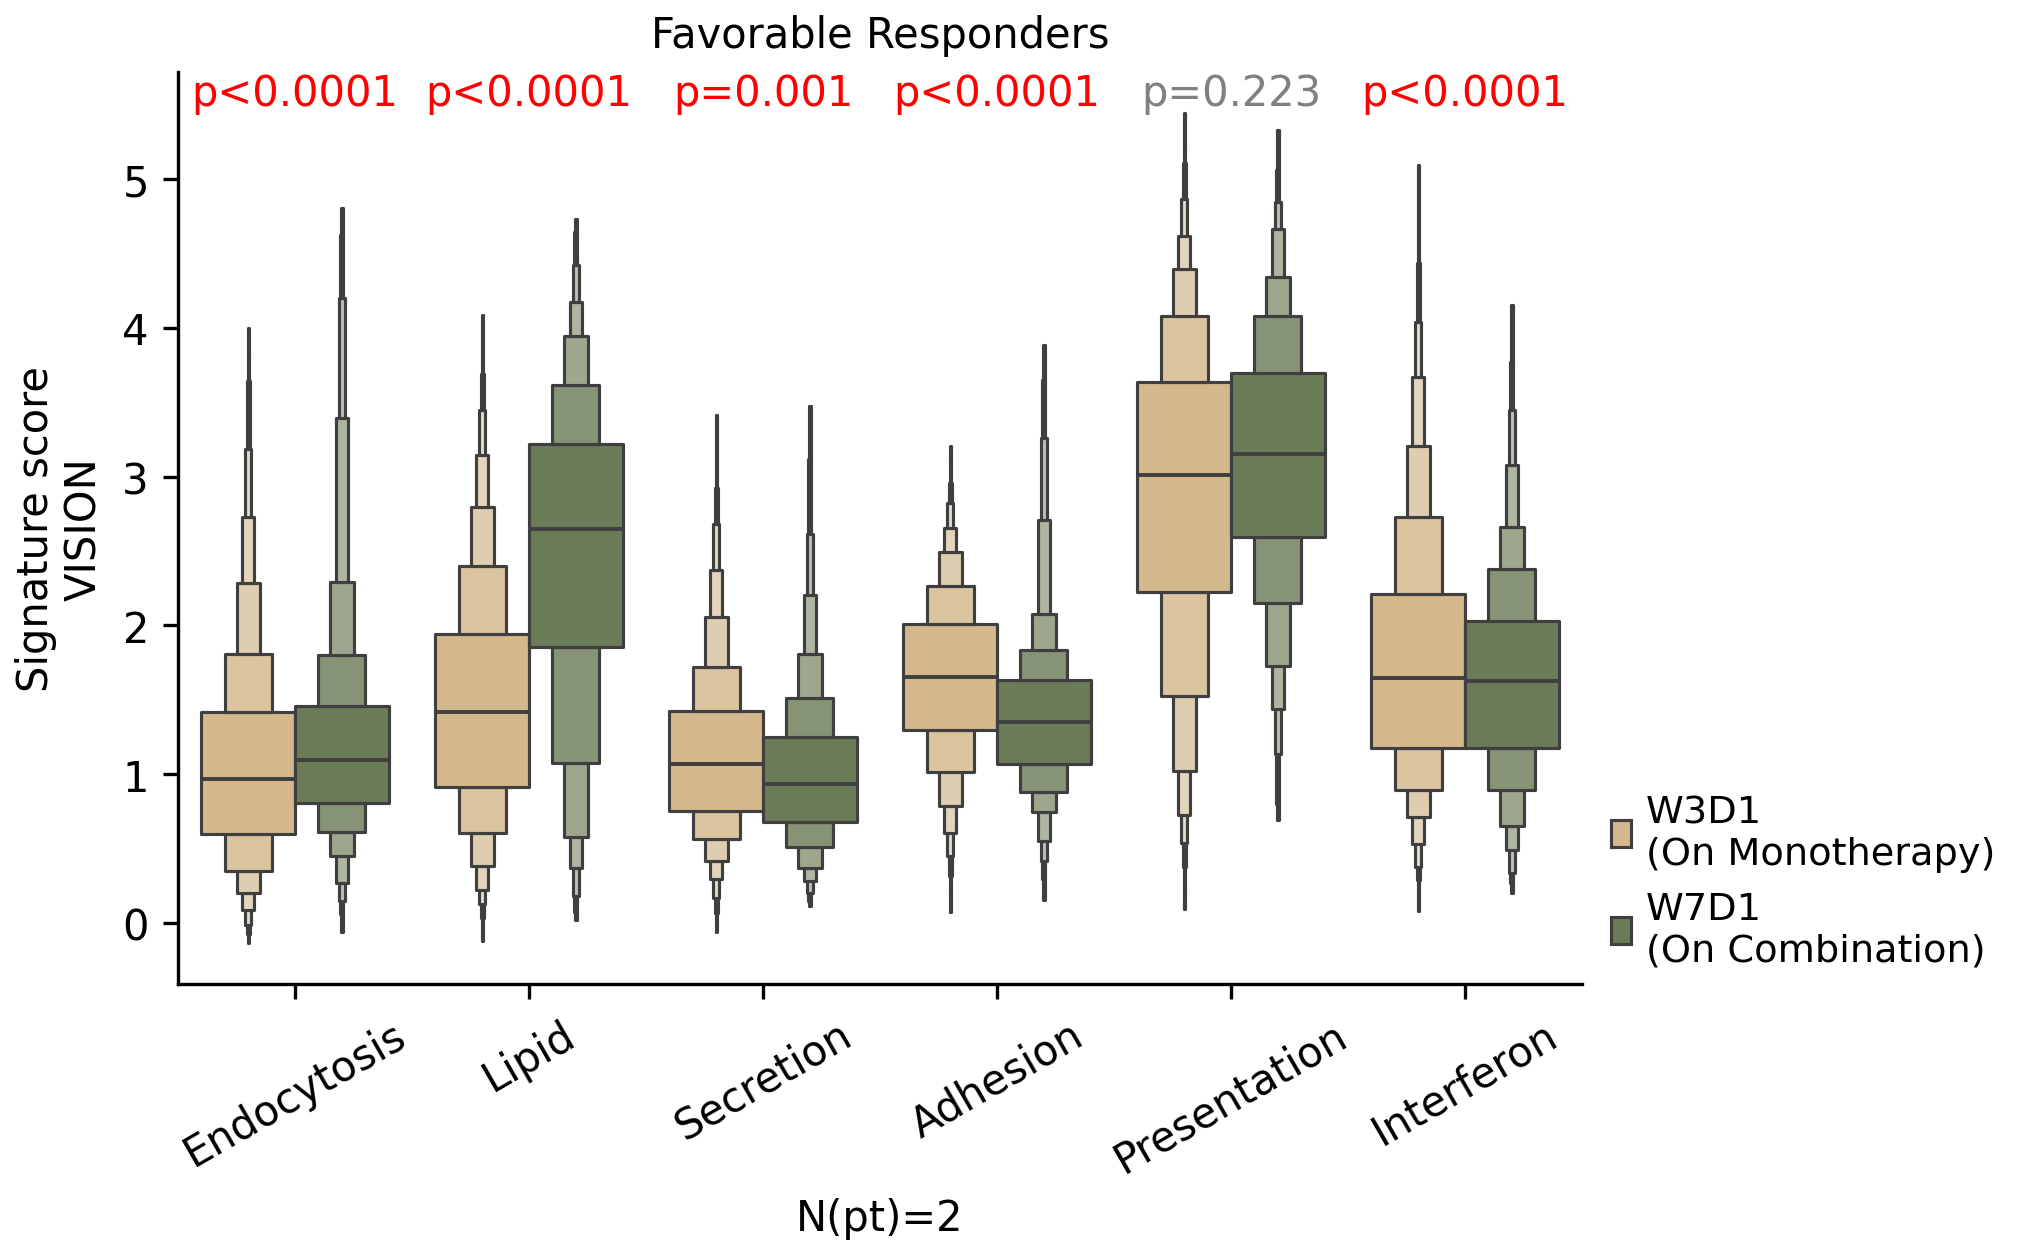

In [83]:
# show_mps = result.loc[(result.Pvalue<0.05)&(result[f'Coef'].abs()>.3),:].sort_values('log2FC').Y.tolist()
# show_mps= ['Adhesion', 'Interferon', 'Lipid']
# show_mps = ['Endocytosis','Presentation']
# show_mps = list(MP_anno_map.values())
show_mps = ['Endocytosis','Lipid','Secretion','Adhesion','Presentation','Interferon']#result.sort_values('Coef').Y.unique().tolist()
pvalues = result.loc[(result.Y.isin(show_mps)),:].set_index('Y')['Pvalue']
dt.rename(columns=MP_anno_map,inplace=True)

plot_rename = {'W3D1':'W3D1\n(On Monotherapy)','W7D1':'W7D1\n(On Combination)'}
dt[x] = dt[x].replace(plot_rename)
palette = {}
for k,v in plot_rename.items():
    palette[v] = COLOR_PAlETTE[x][k]
    
fig,ax=plt.subplots(1,1,figsize=(6,4),dpi=150)
sns.boxenplot(data=dt[show_mps+[x]].melt(id_vars=[x]),
                x='variable',y='value',hue=x,showfliers=False,
                palette=palette,ax=ax)
y_loc =ax.get_ylim()[1]
for xtick in ax.get_xticklabels():
    x_loc,_ = xtick.get_position()
    text = xtick.get_text()
    label = f"p={pvalues[text]:.3f}" if pvalues[text] >= 0.0001 else "p<0.0001"
    if pvalues[text] >= 0.05:
        c='gray'
    else:
        c = 'red'
    ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c)
ax.set(xlabel=f"N(pt)={dt['Patient'].nunique()}",ylabel=f"Signature score\n{signature_method}",title='Favorable Responders')
# ax.set_xticklabels([])
ax.tick_params(axis='x',rotation=30)
ax.legend(loc=(1.01,0),frameon=False,ncol=1)
ax.grid(False)
ax.spines[['right','top']].set_visible(False);

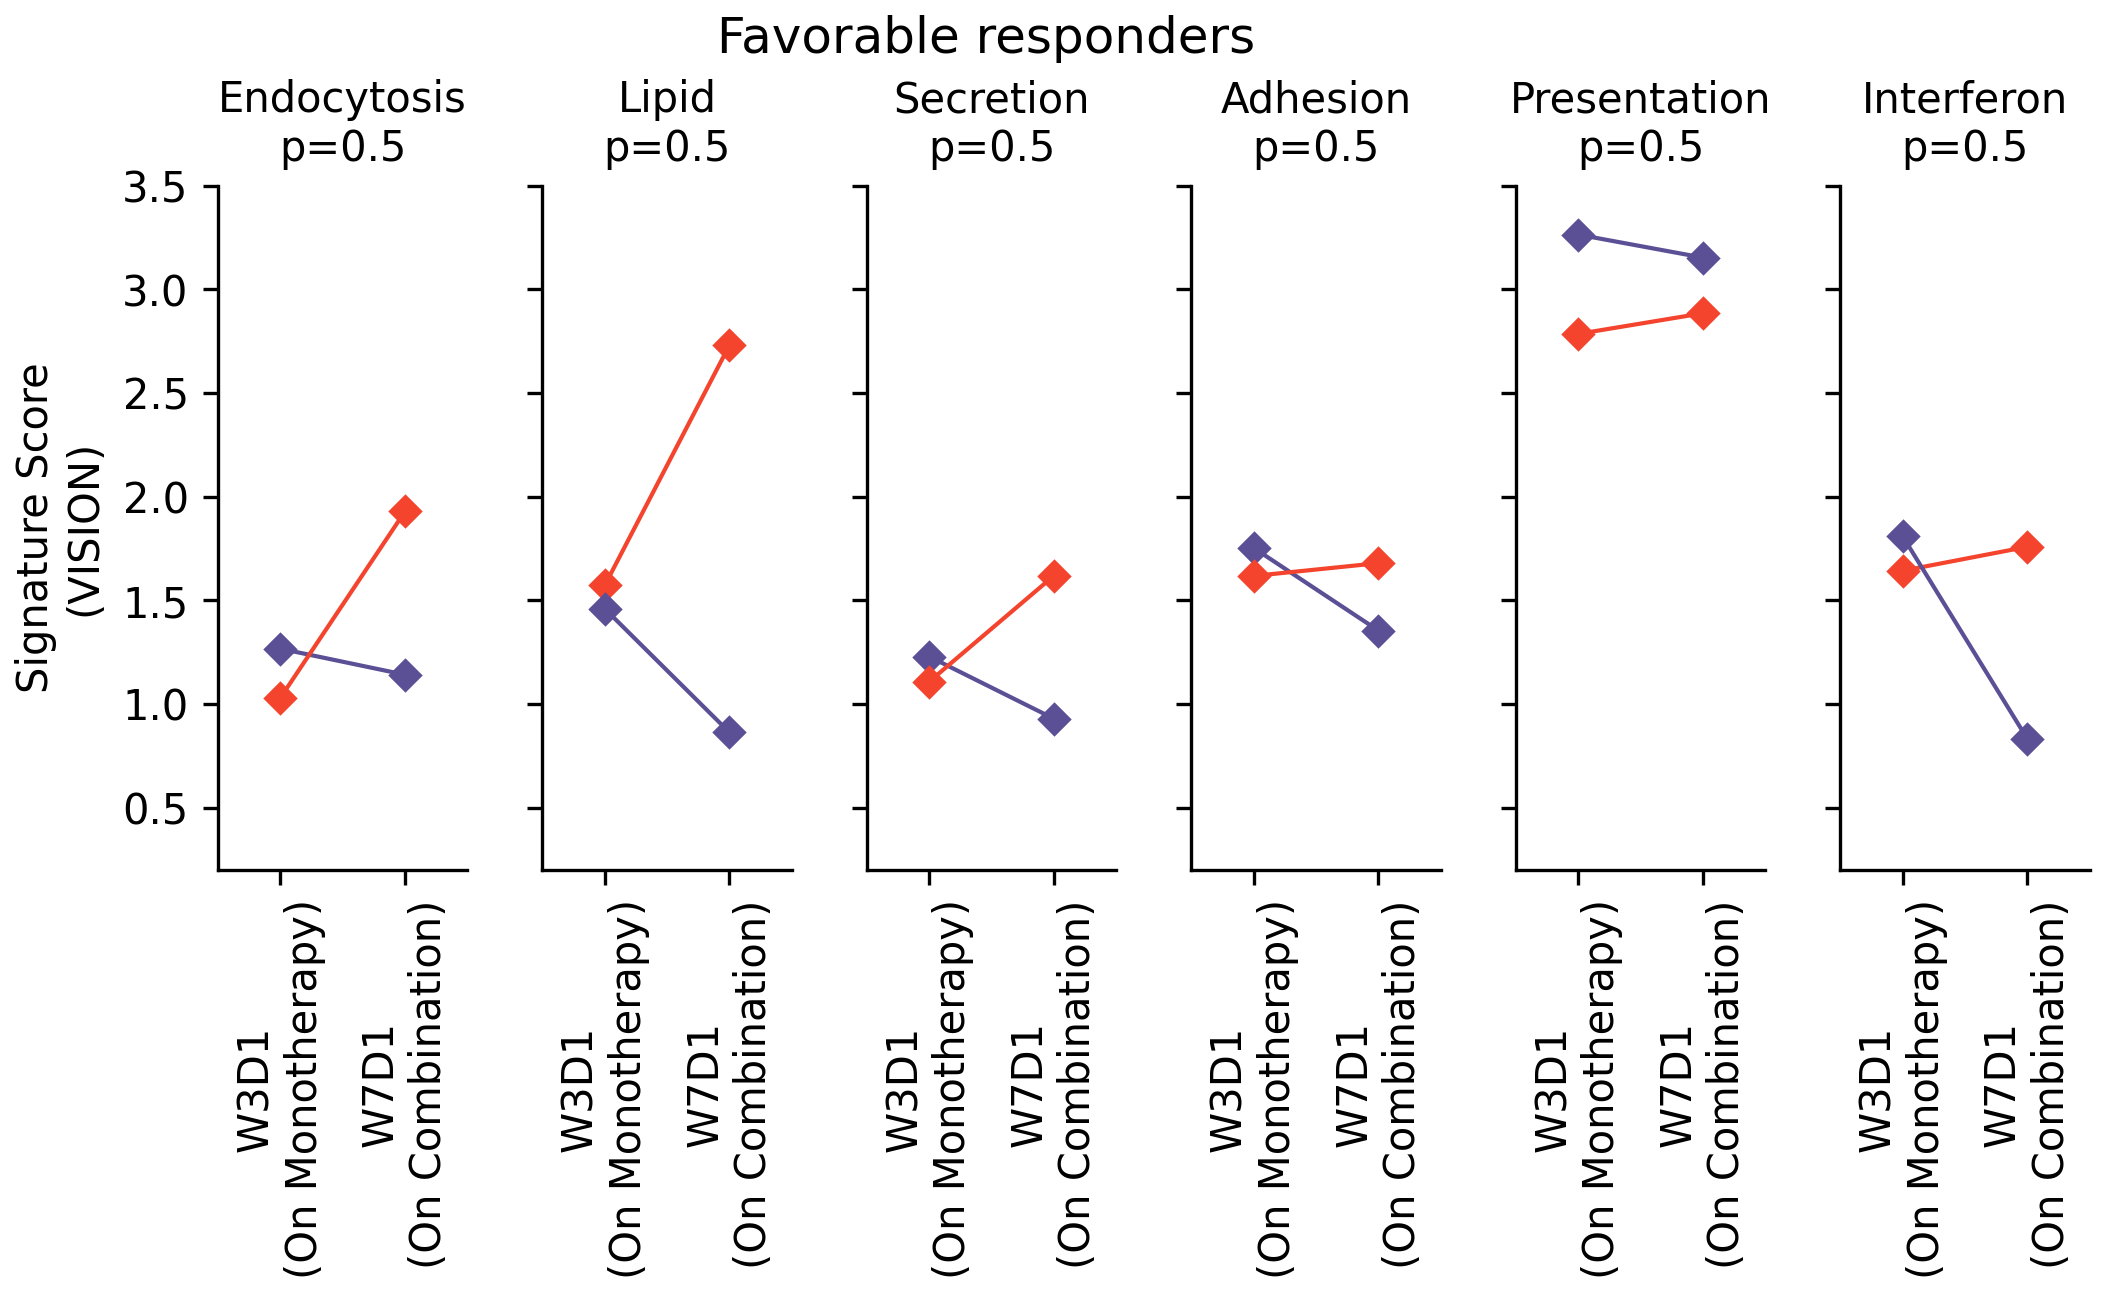

In [84]:
pseudo_dt = dt.groupby(['Patient','Timepoint'])[show_mps].mean().dropna(how='all',axis=0).reset_index()
pseudo_dt.Patient = pseudo_dt.Patient.astype(str)
fig,axs=plt.subplots(1,len(show_mps),figsize=(8,3),dpi=150,sharey=True)
for i,y in enumerate(show_mps):
    ax=axs[i]
    delta = pseudo_dt.pivot_table(index='Patient',columns='Timepoint',values=y).diff(axis=1)['W7D1\n(On Combination)']
    z,p = wilcoxon(delta.values,alternative='greater' if delta.sum()>0 else 'less')
    palette = delta.map(lambda x:"#f4442e" if x >0 else "#5b5095").to_dict()
    # palette = pseudo_dt[['Patient','BestResponse']].drop_duplicates().set_index('Patient')['BestResponse'].map(COLOR_PAlETTE['BestResponse']).to_dict()
    sns.pointplot(data=pseudo_dt,
                   ax=ax,
                  order=['W3D1\n(On Monotherapy)','W7D1\n(On Combination)'],
                  x='Timepoint',y=y,hue='Patient',
                  palette=palette,marker="D",markersize=5,linewidth=1)
    ax.set_ylim([.2,3.5])
    ax.legend_.remove()
    ax.set(xlabel='',ylabel='Signature Score\n(VISION)',title=f"{y}\np={p:.3}")
    ax.tick_params(axis='x',rotation=90)
    ax.grid(False)
plt.subplots_adjust(wspace=.3)
plt.suptitle('Favorable responders',y=1.1);